<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-1">Project description</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2">Data Preparation</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-3">Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Trend-and-Seasonality" data-toc-modified-id="Trend-and-Seasonality-3.1">Trend and Seasonality</a></span></li><li><span><a href="#Feature-Generation" data-toc-modified-id="Feature-Generation-3.2">Feature Generation</a></span></li><li><span><a href="#Train-&amp;-Test-Split" data-toc-modified-id="Train-&amp;-Test-Split-3.3">Train &amp; Test Split</a></span></li></ul></li><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-4">Model Selection</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1">Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regression" data-toc-modified-id="Random-Forest-Regression-4.2">Random Forest Regression</a></span></li><li><span><a href="#KNeighborsRegressor" data-toc-modified-id="KNeighborsRegressor-4.3">KNeighborsRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.4">LGBMRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.5">CatBoost</a></span></li><li><span><a href="#Dummy-models" data-toc-modified-id="Dummy-models-4.6">Dummy models</a></span><ul class="toc-item"><li><span><a href="#Constant-Model" data-toc-modified-id="Constant-Model-4.6.1">Constant Model</a></span></li><li><span><a href="#Naive-Model" data-toc-modified-id="Naive-Model-4.6.2">Naive Model</a></span></li></ul></li></ul></li><li><span><a href="#Models-Comparison" data-toc-modified-id="Models-Comparison-5">Models Comparison</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, the amount of taxi orders for the next hour needs to be predicted.<br>
<b>The task</b> is to develop a model for taxi orders predictions with RMSE no more than 48. The data needs to be re-sampled by one hour.<br>
<b>Data description</b>
Time series data was provided and it includes:<br>
<i>datetime</i> — a time stamp<br>
<i>num_orders</i> — number of order per a time stamp<br>

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from IPython.display import Image
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)

In [3]:
print('Begining of the period', df.index.min(), 'End of the period', df.index.max())

Begining of the period 2018-03-01 00:00:00 End of the period 2018-08-31 23:50:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data set contains 26496 rows and there are no missing values. We set time stamp data as indices and sorted the data by the time stamp in chronological order. The observed data is for the period of time from March 1st to August 31st.

# Data Analysis

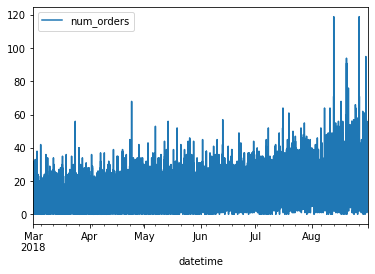

In [5]:
df.plot();

The project's requirement is to re-sample data by one hour.

In [6]:
df = df.resample('1H').sum()

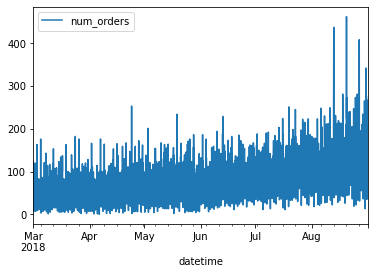

In [7]:
df.plot();

The graph looks still pretty dense after re-sampling by one hour. For the better understanding of what features we need, we might look at different levels of re-sampling later.

## Trend and Seasonality

In [8]:
decomposed = seasonal_decompose(df)

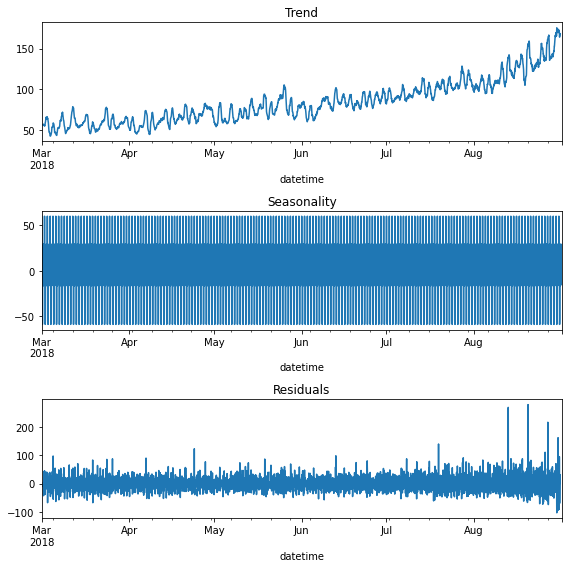

In [9]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()    

Let's take at look at amplitude of swings of the seasonality up close. To reduce the frequency of lines we might need to create a copy of the data set and re-sample it by one day.

In [10]:
df_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_day)

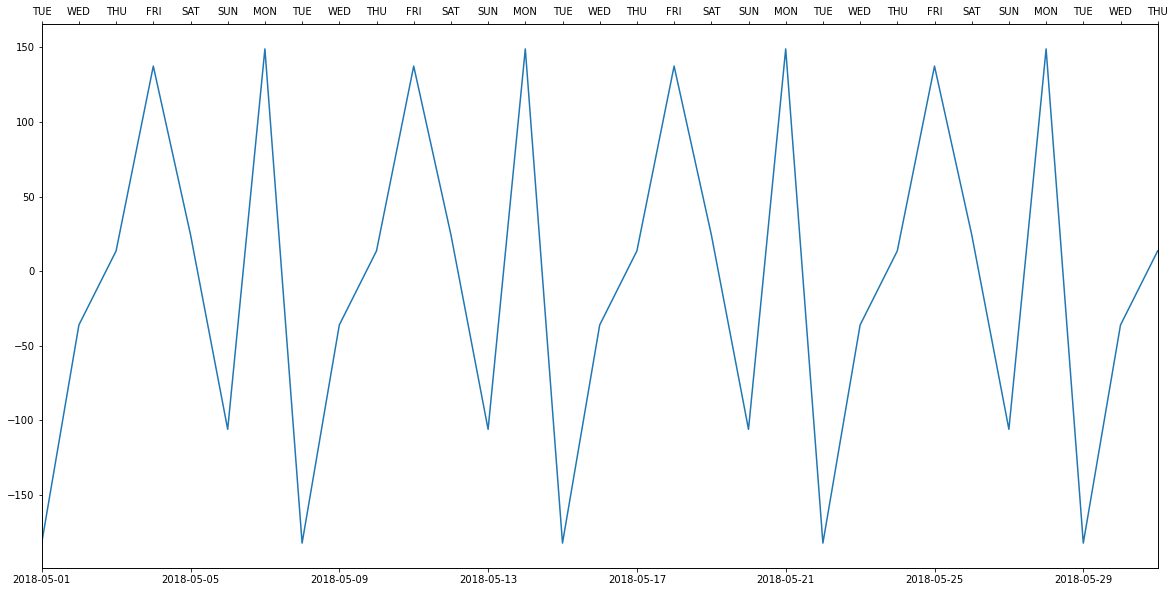

In [11]:
Y = decomposed.seasonal['2018-05-01':'2018-05-31']
x = decomposed.seasonal['2018-05-01':'2018-05-31'].index
weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}
dow = decomposed.seasonal['2018-05-01':'2018-05-31'].index.dayofweek.map(weekday_map)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(len(x)), minor=False)
ax2.set_xticklabels(dow)
ax1.set_xlim(min(x), max(x))
ax1.plot(x, Y);

There is obvious seasonality trend in the data: the peak of taxi rides is on Mondays, the second highest peak is on Fridays. That is why we will need to create a day of the week feature.

## Feature Generation

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
df = make_features(df, 5, 7)

In [14]:
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,42.571429


## Train & Test Split

Now that the new features are ready, let's split the data into train and test sets.

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
train_X = train.drop(['num_orders'], axis=1)
test_X = test.drop(['num_orders'], axis=1)
train_y = train['num_orders']
test_y = test['num_orders']

In order to find best hyper-parameters we will perform grid search cross validation. Since we have time-series data we will use time-aware cross validation technique, which can be explained as follows:

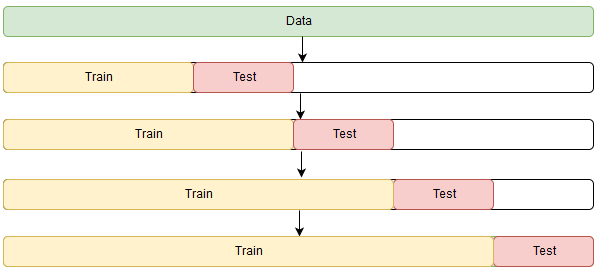

In [16]:
Image(filename='time_aware_cv.png')

Source: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [17]:
time_split = TimeSeriesSplit(n_splits=3)

# Model Selection

## Linear Regression

In [18]:
lm = LinearRegression()
lm.fit(train_X, train_y)

LinearRegression()

In [19]:
%%time
lm_predictions_test = lm.predict(test_X)

CPU times: user 8.91 ms, sys: 715 µs, total: 9.62 ms
Wall time: 2.41 ms


In [20]:
lm_rmse_test = round(mean_squared_error(test_y, lm_predictions_test)**0.5, 2)
print('RMSE on test:', lm_rmse_test)

RMSE on test: 47.52


## Random Forest Regression

In [21]:
rfr = RandomForestRegressor()

In [22]:
param_grid = { 
    'n_estimators': [10, 25, 50, 75, 100],
    'max_depth' : [i for i in range(3,15,3)]
}

In [23]:
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=time_split, scoring='neg_root_mean_squared_error')
CV_rfr.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 25, 50, 75, 100]},
             scoring='neg_root_mean_squared_error')

In [24]:
CV_rfr.best_params_

{'max_depth': 12, 'n_estimators': 75}

In [25]:
-CV_rfr.best_score_

25.263978609401985

In [26]:
%%time
rfr_best_pred_test = CV_rfr.predict(test_X)

CPU times: user 11.5 ms, sys: 985 µs, total: 12.4 ms
Wall time: 11.5 ms


In [27]:
rfr_rmse_test = round(mean_squared_error(test_y, rfr_best_pred_test)**0.5, 2)
print('RMSE on test:', rfr_rmse_test)

RMSE on test: 44.55


## KNeighborsRegressor

In [28]:
knn = KNeighborsRegressor()

In [29]:
param_grid = {
        'n_neighbors' : range(1,5,1),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
knn_CV = GridSearchCV(estimator = knn, param_grid = param_grid, cv=time_split, scoring = 'neg_root_mean_squared_error')
knn_CV.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 5)},
             scoring='neg_root_mean_squared_error')

In [30]:
knn_CV.best_params_

{'algorithm': 'auto', 'n_neighbors': 4}

In [31]:
-knn_CV.best_score_

33.310054112409034

In [32]:
%%time
knn_best_pred_test = knn_CV.predict(test_X)

CPU times: user 52 ms, sys: 2.48 ms, total: 54.5 ms
Wall time: 14.7 ms


In [33]:
knn_rmse_test = round(mean_squared_error(test_y, knn_best_pred_test)**0.5, 2)
print('RMSE on test:', knn_rmse_test)

RMSE on test: 57.57


## LGBMRegressor

In [34]:
lgbm_model = LGBMRegressor()

In [35]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400], #Number of boosted trees to fit.
    'max_depth': [5, 10, 15, 20, 25] #Maximum tree depth for base learners, <=0 means no limit.
}

In [36]:
grid_search_lgbm = GridSearchCV(estimator=lgbm_model,
                                param_grid=param_grid,
                                cv=time_split,
                                scoring='neg_root_mean_squared_error')

In [37]:
grid_search_lgbm.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_root_mean_squared_error')

In [38]:
grid_search_lgbm.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

In [39]:
lgbm_best = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=100)

In [40]:
lgbm_best.fit(train_X, train_y)

LGBMRegressor(learning_rate=0.05, max_depth=10)

In [41]:
%%time
lgbm_predictions_test = lgbm_best.predict(test_X)

CPU times: user 23.6 ms, sys: 3.22 ms, total: 26.9 ms
Wall time: 4.28 ms


In [42]:
lgbm_rmse_test = round(mean_squared_error(test_y, lgbm_predictions_test)**0.5, 2)
print('RMSE on test:', lgbm_rmse_test)

RMSE on test: 45.39


## CatBoost

In [43]:
catboost = CatBoostRegressor()

In [44]:
param_grid = {'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'depth': [6, 8, 10],
        'l2_leaf_reg': [1, 3, 5]}

In [45]:
grid_search_result = catboost.grid_search(param_grid, X=train_X, y=train_y, cv=time_split)

0:	learn: 73.1823120	test: 99.2036382	best: 99.2036382 (0)	total: 58.9ms	remaining: 5.83s
1:	learn: 70.1485756	test: 95.5931749	best: 95.5931749 (1)	total: 63.4ms	remaining: 3.11s
2:	learn: 67.2819918	test: 92.6287629	best: 92.6287629 (2)	total: 67.2ms	remaining: 2.17s
3:	learn: 64.6433207	test: 89.4009714	best: 89.4009714 (3)	total: 71.1ms	remaining: 1.71s
4:	learn: 62.0597538	test: 86.4865719	best: 86.4865719 (4)	total: 75.8ms	remaining: 1.44s
5:	learn: 59.5793980	test: 83.6820250	best: 83.6820250 (5)	total: 81.3ms	remaining: 1.27s
6:	learn: 57.1685216	test: 80.9777714	best: 80.9777714 (6)	total: 86.4ms	remaining: 1.15s
7:	learn: 55.0329115	test: 78.2099326	best: 78.2099326 (7)	total: 89.9ms	remaining: 1.03s
8:	learn: 52.9825466	test: 75.7136500	best: 75.7136500 (8)	total: 94ms	remaining: 950ms
9:	learn: 51.0039000	test: 73.2851104	best: 73.2851104 (9)	total: 98.7ms	remaining: 888ms
10:	learn: 49.2558679	test: 71.1890139	best: 71.1890139 (10)	total: 103ms	remaining: 835ms
11:	learn: 

17:	learn: 26.5128244	test: 40.2493197	best: 40.2493197 (17)	total: 27.1ms	remaining: 123ms
18:	learn: 25.7801374	test: 38.9496252	best: 38.9496252 (18)	total: 29ms	remaining: 124ms
19:	learn: 25.1657150	test: 37.8939369	best: 37.8939369 (19)	total: 31.7ms	remaining: 127ms
20:	learn: 24.6905887	test: 36.9517898	best: 36.9517898 (20)	total: 34.1ms	remaining: 128ms
21:	learn: 24.2247726	test: 36.0962834	best: 36.0962834 (21)	total: 36.3ms	remaining: 129ms
22:	learn: 23.7702437	test: 35.0971369	best: 35.0971369 (22)	total: 39.1ms	remaining: 131ms
23:	learn: 23.4794860	test: 34.4819757	best: 34.4819757 (23)	total: 41.2ms	remaining: 130ms
24:	learn: 23.1915386	test: 33.9306813	best: 33.9306813 (24)	total: 43.7ms	remaining: 131ms
25:	learn: 22.9622830	test: 33.4892075	best: 33.4892075 (25)	total: 46.6ms	remaining: 133ms
26:	learn: 22.7177041	test: 32.9889564	best: 32.9889564 (26)	total: 50.2ms	remaining: 136ms
27:	learn: 22.4371053	test: 32.4973937	best: 32.4973937 (27)	total: 53.4ms	remaini

44:	learn: 19.1018373	test: 28.1872872	best: 28.1872872 (44)	total: 90.4ms	remaining: 110ms
45:	learn: 19.0298129	test: 28.1931025	best: 28.1872872 (44)	total: 92.5ms	remaining: 109ms
46:	learn: 18.9308749	test: 28.1511898	best: 28.1511898 (46)	total: 94.9ms	remaining: 107ms
47:	learn: 18.8456075	test: 28.1281210	best: 28.1281210 (47)	total: 96.8ms	remaining: 105ms
48:	learn: 18.7198959	test: 28.0289050	best: 28.0289050 (48)	total: 98.9ms	remaining: 103ms
49:	learn: 18.6732598	test: 27.9750387	best: 27.9750387 (49)	total: 101ms	remaining: 101ms
50:	learn: 18.6108637	test: 27.9360941	best: 27.9360941 (50)	total: 103ms	remaining: 98.9ms
51:	learn: 18.5787702	test: 27.9382381	best: 27.9360941 (50)	total: 105ms	remaining: 97ms
52:	learn: 18.4898778	test: 27.8318278	best: 27.8318278 (52)	total: 107ms	remaining: 95.2ms
53:	learn: 18.3867084	test: 27.8375318	best: 27.8318278 (52)	total: 109ms	remaining: 93ms
54:	learn: 18.2953418	test: 27.8197263	best: 27.8197263 (54)	total: 112ms	remaining: 

44:	learn: 24.7154509	test: 36.5665271	best: 36.5665271 (44)	total: 96ms	remaining: 117ms
45:	learn: 24.5574942	test: 36.1784503	best: 36.1784503 (45)	total: 98ms	remaining: 115ms
46:	learn: 24.4036384	test: 35.9259562	best: 35.9259562 (46)	total: 100ms	remaining: 113ms
47:	learn: 24.2024170	test: 35.5430810	best: 35.5430810 (47)	total: 102ms	remaining: 111ms
48:	learn: 24.0621781	test: 35.2431681	best: 35.2431681 (48)	total: 104ms	remaining: 108ms
49:	learn: 23.8332385	test: 34.9082835	best: 34.9082835 (49)	total: 107ms	remaining: 107ms
50:	learn: 23.6776317	test: 34.5936505	best: 34.5936505 (50)	total: 108ms	remaining: 104ms
51:	learn: 23.4971902	test: 34.1859443	best: 34.1859443 (51)	total: 110ms	remaining: 102ms
52:	learn: 23.3710958	test: 34.0058317	best: 34.0058317 (52)	total: 112ms	remaining: 99.7ms
53:	learn: 23.2639054	test: 33.8092577	best: 33.8092577 (53)	total: 116ms	remaining: 98.8ms
54:	learn: 23.1631123	test: 33.5743940	best: 33.5743940 (54)	total: 119ms	remaining: 97.5m

45:	learn: 20.8480805	test: 29.5294383	best: 29.5294383 (45)	total: 96.4ms	remaining: 113ms
46:	learn: 20.6992741	test: 29.3221271	best: 29.3221271 (46)	total: 98.9ms	remaining: 112ms
47:	learn: 20.6109577	test: 29.2593188	best: 29.2593188 (47)	total: 100ms	remaining: 109ms
48:	learn: 20.4972611	test: 29.2011752	best: 29.2011752 (48)	total: 102ms	remaining: 106ms
49:	learn: 20.4022790	test: 29.0781741	best: 29.0781741 (49)	total: 103ms	remaining: 103ms
50:	learn: 20.3624418	test: 29.0359715	best: 29.0359715 (50)	total: 104ms	remaining: 100ms
51:	learn: 20.3177554	test: 28.9795344	best: 28.9795344 (51)	total: 105ms	remaining: 97.3ms
52:	learn: 20.2394144	test: 28.9861164	best: 28.9795344 (51)	total: 107ms	remaining: 94.9ms
53:	learn: 20.1579635	test: 28.8355971	best: 28.8355971 (53)	total: 109ms	remaining: 92.8ms
54:	learn: 20.0559405	test: 28.7292422	best: 28.7292422 (54)	total: 111ms	remaining: 90.9ms
55:	learn: 19.9888005	test: 28.7288288	best: 28.7288288 (55)	total: 113ms	remaining:

41:	learn: 19.5889776	test: 28.5283513	best: 28.5132151 (40)	total: 96.6ms	remaining: 133ms
42:	learn: 19.5061932	test: 28.4843160	best: 28.4843160 (42)	total: 99.3ms	remaining: 132ms
43:	learn: 19.4684105	test: 28.4739741	best: 28.4739741 (43)	total: 101ms	remaining: 129ms
44:	learn: 19.4325247	test: 28.4989875	best: 28.4739741 (43)	total: 104ms	remaining: 127ms
45:	learn: 19.3935223	test: 28.5047910	best: 28.4739741 (43)	total: 105ms	remaining: 124ms
46:	learn: 19.2995968	test: 28.4458656	best: 28.4458656 (46)	total: 107ms	remaining: 121ms
47:	learn: 19.2042856	test: 28.3453481	best: 28.3453481 (47)	total: 110ms	remaining: 119ms
48:	learn: 19.1015947	test: 28.3317030	best: 28.3317030 (48)	total: 112ms	remaining: 116ms
49:	learn: 19.0124978	test: 28.3250513	best: 28.3250513 (49)	total: 115ms	remaining: 115ms
50:	learn: 18.9740668	test: 28.3081608	best: 28.3081608 (50)	total: 118ms	remaining: 113ms
51:	learn: 18.9375400	test: 28.3069140	best: 28.3069140 (51)	total: 123ms	remaining: 113

75:	learn: 21.6510302	test: 30.5493404	best: 30.5493404 (75)	total: 150ms	remaining: 47.3ms
76:	learn: 21.5903700	test: 30.4309353	best: 30.4309353 (76)	total: 152ms	remaining: 45.3ms
77:	learn: 21.5544821	test: 30.3535752	best: 30.3535752 (77)	total: 154ms	remaining: 43.5ms
78:	learn: 21.5264900	test: 30.3109930	best: 30.3109930 (78)	total: 156ms	remaining: 41.5ms
79:	learn: 21.4791721	test: 30.2185832	best: 30.2185832 (79)	total: 159ms	remaining: 39.9ms
80:	learn: 21.3960149	test: 30.1139717	best: 30.1139717 (80)	total: 164ms	remaining: 38.5ms
81:	learn: 21.3405112	test: 30.0542154	best: 30.0542154 (81)	total: 167ms	remaining: 36.6ms
82:	learn: 21.3097740	test: 29.9793993	best: 29.9793993 (82)	total: 169ms	remaining: 34.6ms
83:	learn: 21.2546358	test: 29.9155327	best: 29.9155327 (83)	total: 171ms	remaining: 32.6ms
84:	learn: 21.1928996	test: 29.7895725	best: 29.7895725 (84)	total: 173ms	remaining: 30.6ms
85:	learn: 21.1569068	test: 29.7279646	best: 29.7279646 (85)	total: 177ms	remain

82:	learn: 18.6641841	test: 27.7414998	best: 27.7311279 (81)	total: 131ms	remaining: 26.9ms
83:	learn: 18.6532726	test: 27.7389502	best: 27.7311279 (81)	total: 133ms	remaining: 25.4ms
84:	learn: 18.6059553	test: 27.7599615	best: 27.7311279 (81)	total: 135ms	remaining: 23.9ms
85:	learn: 18.5635618	test: 27.7353559	best: 27.7311279 (81)	total: 138ms	remaining: 22.5ms
86:	learn: 18.5091382	test: 27.7389251	best: 27.7311279 (81)	total: 140ms	remaining: 21ms
87:	learn: 18.4614060	test: 27.7426854	best: 27.7311279 (81)	total: 144ms	remaining: 19.6ms
88:	learn: 18.4239240	test: 27.6680558	best: 27.6680558 (88)	total: 148ms	remaining: 18.3ms
89:	learn: 18.3819720	test: 27.7074666	best: 27.6680558 (88)	total: 150ms	remaining: 16.6ms
90:	learn: 18.3629671	test: 27.6957372	best: 27.6680558 (88)	total: 152ms	remaining: 15ms
91:	learn: 18.3258534	test: 27.7010489	best: 27.6680558 (88)	total: 154ms	remaining: 13.4ms
92:	learn: 18.2877632	test: 27.6748427	best: 27.6680558 (88)	total: 158ms	remaining:

89:	learn: 17.2543760	test: 27.4477743	best: 27.4477743 (89)	total: 142ms	remaining: 15.8ms
90:	learn: 17.2386766	test: 27.4291461	best: 27.4291461 (90)	total: 145ms	remaining: 14.3ms
91:	learn: 17.2310524	test: 27.4285572	best: 27.4285572 (91)	total: 148ms	remaining: 12.8ms
92:	learn: 17.1807631	test: 27.3772105	best: 27.3772105 (92)	total: 150ms	remaining: 11.3ms
93:	learn: 17.1794378	test: 27.3747398	best: 27.3747398 (93)	total: 152ms	remaining: 9.73ms
94:	learn: 17.1763957	test: 27.3735537	best: 27.3735537 (94)	total: 156ms	remaining: 8.2ms
95:	learn: 17.1219976	test: 27.3765470	best: 27.3735537 (94)	total: 158ms	remaining: 6.6ms
96:	learn: 17.0523989	test: 27.2656558	best: 27.2656558 (96)	total: 161ms	remaining: 4.97ms
97:	learn: 16.9976750	test: 27.2787030	best: 27.2656558 (96)	total: 163ms	remaining: 3.33ms
98:	learn: 16.9528111	test: 27.2820993	best: 27.2656558 (96)	total: 166ms	remaining: 1.68ms
99:	learn: 16.8818653	test: 27.2668378	best: 27.2656558 (96)	total: 169ms	remainin

98:	learn: 20.0386928	test: 28.6511808	best: 28.6511808 (98)	total: 159ms	remaining: 162ms
99:	learn: 19.9895852	test: 28.5878851	best: 28.5878851 (99)	total: 162ms	remaining: 162ms
100:	learn: 19.9389195	test: 28.5419922	best: 28.5419922 (100)	total: 164ms	remaining: 161ms
101:	learn: 19.9142324	test: 28.5310234	best: 28.5310234 (101)	total: 168ms	remaining: 161ms
102:	learn: 19.8589330	test: 28.4671661	best: 28.4671661 (102)	total: 171ms	remaining: 161ms
103:	learn: 19.8278107	test: 28.4159117	best: 28.4159117 (103)	total: 173ms	remaining: 160ms
104:	learn: 19.8156007	test: 28.3841572	best: 28.3841572 (104)	total: 176ms	remaining: 159ms
105:	learn: 19.7901171	test: 28.3142906	best: 28.3142906 (105)	total: 178ms	remaining: 158ms
106:	learn: 19.7315066	test: 28.2643217	best: 28.2643217 (106)	total: 182ms	remaining: 158ms
107:	learn: 19.6790159	test: 28.2101770	best: 28.2101770 (107)	total: 185ms	remaining: 157ms
108:	learn: 19.6589202	test: 28.2105832	best: 28.2101770 (107)	total: 187m

4:	learn: 50.8696366	test: 72.9207902	best: 72.9207902 (4)	total: 6.64ms	remaining: 259ms
5:	learn: 47.2111927	test: 68.5537112	best: 68.5537112 (5)	total: 10ms	remaining: 324ms
6:	learn: 44.0541002	test: 64.7054893	best: 64.7054893 (6)	total: 12.1ms	remaining: 333ms
7:	learn: 41.0535957	test: 60.6881072	best: 60.6881072 (7)	total: 15.3ms	remaining: 367ms
8:	learn: 38.6148448	test: 57.5852298	best: 57.5852298 (8)	total: 18.6ms	remaining: 395ms
9:	learn: 36.3683078	test: 54.7305142	best: 54.7305142 (9)	total: 20.8ms	remaining: 396ms
10:	learn: 34.4691860	test: 52.4500942	best: 52.4500942 (10)	total: 23.8ms	remaining: 409ms
11:	learn: 32.7320424	test: 50.0608321	best: 50.0608321 (11)	total: 25.9ms	remaining: 405ms
12:	learn: 31.3493900	test: 47.9097568	best: 47.9097568 (12)	total: 28.7ms	remaining: 412ms
13:	learn: 29.9454430	test: 45.5969011	best: 45.5969011 (13)	total: 31.7ms	remaining: 421ms
14:	learn: 28.8847245	test: 43.8757922	best: 43.8757922 (14)	total: 34.5ms	remaining: 426ms
15

113:	learn: 16.7826132	test: 27.1418683	best: 27.1215492 (112)	total: 194ms	remaining: 147ms
114:	learn: 16.7442741	test: 27.1381688	best: 27.1215492 (112)	total: 198ms	remaining: 146ms
115:	learn: 16.7173883	test: 27.1343102	best: 27.1215492 (112)	total: 200ms	remaining: 145ms
116:	learn: 16.7012004	test: 27.1439296	best: 27.1215492 (112)	total: 204ms	remaining: 144ms
117:	learn: 16.6844724	test: 27.1430510	best: 27.1215492 (112)	total: 206ms	remaining: 143ms
118:	learn: 16.6686146	test: 27.1520261	best: 27.1215492 (112)	total: 208ms	remaining: 142ms
119:	learn: 16.6429474	test: 27.1637670	best: 27.1215492 (112)	total: 210ms	remaining: 140ms
120:	learn: 16.6260345	test: 27.1610307	best: 27.1215492 (112)	total: 212ms	remaining: 138ms
121:	learn: 16.5922903	test: 27.1564793	best: 27.1215492 (112)	total: 214ms	remaining: 137ms
122:	learn: 16.5559518	test: 27.1399078	best: 27.1215492 (112)	total: 217ms	remaining: 136ms
123:	learn: 16.5246547	test: 27.1223637	best: 27.1215492 (112)	total: 

21:	learn: 21.6951652	test: 31.0842474	best: 31.0842474 (21)	total: 31.3ms	remaining: 253ms
22:	learn: 21.4610924	test: 30.6896921	best: 30.6896921 (22)	total: 33.8ms	remaining: 260ms
23:	learn: 21.2463752	test: 30.4278538	best: 30.4278538 (23)	total: 37.4ms	remaining: 275ms
24:	learn: 21.1176465	test: 30.3165716	best: 30.3165716 (24)	total: 39.9ms	remaining: 279ms
25:	learn: 21.0349473	test: 30.1270501	best: 30.1270501 (25)	total: 41.9ms	remaining: 280ms
26:	learn: 20.8758044	test: 30.0518881	best: 30.0518881 (26)	total: 43.9ms	remaining: 282ms
27:	learn: 20.7684881	test: 29.8986528	best: 29.8986528 (27)	total: 45.9ms	remaining: 282ms
28:	learn: 20.6810187	test: 29.6820813	best: 29.6820813 (28)	total: 49.1ms	remaining: 289ms
29:	learn: 20.5629223	test: 29.5342319	best: 29.5342319 (29)	total: 52.1ms	remaining: 295ms
30:	learn: 20.4953644	test: 29.4064317	best: 29.4064317 (30)	total: 56ms	remaining: 305ms
31:	learn: 20.4466390	test: 29.2947583	best: 29.2947583 (31)	total: 58ms	remaining

130:	learn: 14.4835124	test: 27.0033954	best: 26.9686847 (121)	total: 219ms	remaining: 115ms
131:	learn: 14.4702052	test: 27.0172728	best: 26.9686847 (121)	total: 223ms	remaining: 115ms
132:	learn: 14.4449007	test: 27.0333037	best: 26.9686847 (121)	total: 226ms	remaining: 114ms
133:	learn: 14.3926552	test: 26.9949823	best: 26.9686847 (121)	total: 229ms	remaining: 113ms
134:	learn: 14.3599547	test: 27.0127851	best: 26.9686847 (121)	total: 231ms	remaining: 111ms
135:	learn: 14.3445227	test: 27.0133404	best: 26.9686847 (121)	total: 233ms	remaining: 110ms
136:	learn: 14.2867074	test: 27.0133035	best: 26.9686847 (121)	total: 235ms	remaining: 108ms
137:	learn: 14.2640020	test: 27.0162057	best: 26.9686847 (121)	total: 238ms	remaining: 107ms
138:	learn: 14.2426785	test: 27.0261793	best: 26.9686847 (121)	total: 241ms	remaining: 106ms
139:	learn: 14.2396751	test: 27.0320917	best: 26.9686847 (121)	total: 244ms	remaining: 105ms
140:	learn: 14.2140018	test: 27.0514904	best: 26.9686847 (121)	total: 

35:	learn: 27.4046885	test: 41.2680471	best: 41.2680471 (35)	total: 50.1ms	remaining: 228ms
36:	learn: 27.1117615	test: 40.8214175	best: 40.8214175 (36)	total: 53.7ms	remaining: 237ms
37:	learn: 26.8123438	test: 40.3253020	best: 40.3253020 (37)	total: 57.5ms	remaining: 245ms
38:	learn: 26.5131973	test: 39.7843624	best: 39.7843624 (38)	total: 59.4ms	remaining: 245ms
39:	learn: 26.1402793	test: 39.1859978	best: 39.1859978 (39)	total: 61.7ms	remaining: 247ms
40:	learn: 25.8138291	test: 38.5854589	best: 38.5854589 (40)	total: 63.9ms	remaining: 248ms
41:	learn: 25.5002889	test: 37.8358760	best: 37.8358760 (41)	total: 66.2ms	remaining: 249ms
42:	learn: 25.2064352	test: 37.3617123	best: 37.3617123 (42)	total: 68.5ms	remaining: 250ms
43:	learn: 24.9475453	test: 36.9665157	best: 36.9665157 (43)	total: 71.7ms	remaining: 254ms
44:	learn: 24.7154509	test: 36.5665271	best: 36.5665271 (44)	total: 74.8ms	remaining: 257ms
45:	learn: 24.5574942	test: 36.1784503	best: 36.1784503 (45)	total: 77.9ms	remai

143:	learn: 18.9973627	test: 27.8189361	best: 27.8189361 (143)	total: 241ms	remaining: 93.9ms
144:	learn: 18.9668525	test: 27.7752043	best: 27.7752043 (144)	total: 245ms	remaining: 92.9ms
145:	learn: 18.9250511	test: 27.7107299	best: 27.7107299 (145)	total: 247ms	remaining: 91.4ms
146:	learn: 18.9010647	test: 27.7085682	best: 27.7085682 (146)	total: 250ms	remaining: 90ms
147:	learn: 18.8743535	test: 27.6758376	best: 27.6758376 (147)	total: 251ms	remaining: 88.1ms
148:	learn: 18.8371210	test: 27.6497087	best: 27.6497087 (148)	total: 253ms	remaining: 86.5ms
149:	learn: 18.8138063	test: 27.6370596	best: 27.6370596 (149)	total: 255ms	remaining: 85ms
150:	learn: 18.7965585	test: 27.6250938	best: 27.6250938 (150)	total: 257ms	remaining: 83.5ms
151:	learn: 18.7823323	test: 27.6131207	best: 27.6131207 (151)	total: 259ms	remaining: 81.9ms
152:	learn: 18.7688093	test: 27.6007710	best: 27.6007710 (152)	total: 263ms	remaining: 80.8ms
153:	learn: 18.7484520	test: 27.5950505	best: 27.5950505 (153)	t

50:	learn: 20.3624418	test: 29.0359715	best: 29.0359715 (50)	total: 76.6ms	remaining: 224ms
51:	learn: 20.3177554	test: 28.9795344	best: 28.9795344 (51)	total: 78.8ms	remaining: 224ms
52:	learn: 20.2394144	test: 28.9861164	best: 28.9795344 (51)	total: 81.3ms	remaining: 225ms
53:	learn: 20.1579635	test: 28.8355971	best: 28.8355971 (53)	total: 83.7ms	remaining: 226ms
54:	learn: 20.0559405	test: 28.7292422	best: 28.7292422 (54)	total: 85.6ms	remaining: 226ms
55:	learn: 19.9888005	test: 28.7288288	best: 28.7288288 (55)	total: 87.8ms	remaining: 226ms
56:	learn: 19.9268988	test: 28.6926556	best: 28.6926556 (56)	total: 89.7ms	remaining: 225ms
57:	learn: 19.8684314	test: 28.6271339	best: 28.6271339 (57)	total: 91.8ms	remaining: 225ms
58:	learn: 19.8205027	test: 28.5629985	best: 28.5629985 (58)	total: 95.1ms	remaining: 227ms
59:	learn: 19.7702957	test: 28.4837946	best: 28.4837946 (59)	total: 98.4ms	remaining: 230ms
60:	learn: 19.7437871	test: 28.4412218	best: 28.4412218 (60)	total: 101ms	remain

160:	learn: 16.2290355	test: 26.6395217	best: 26.6119848 (142)	total: 265ms	remaining: 64.3ms
161:	learn: 16.2091045	test: 26.6545929	best: 26.6119848 (142)	total: 268ms	remaining: 62.8ms
162:	learn: 16.1863223	test: 26.6678366	best: 26.6119848 (142)	total: 270ms	remaining: 61.2ms
163:	learn: 16.1692149	test: 26.6653161	best: 26.6119848 (142)	total: 272ms	remaining: 59.7ms
164:	learn: 16.1683620	test: 26.6659663	best: 26.6119848 (142)	total: 274ms	remaining: 58.2ms
165:	learn: 16.1429772	test: 26.6488508	best: 26.6119848 (142)	total: 277ms	remaining: 56.7ms
166:	learn: 16.1073350	test: 26.6344516	best: 26.6119848 (142)	total: 279ms	remaining: 55.2ms
167:	learn: 16.0603005	test: 26.6178375	best: 26.6119848 (142)	total: 281ms	remaining: 53.5ms
168:	learn: 16.0422757	test: 26.6196503	best: 26.6119848 (142)	total: 284ms	remaining: 52ms
169:	learn: 16.0230081	test: 26.6253811	best: 26.6119848 (142)	total: 287ms	remaining: 50.6ms
170:	learn: 15.9856387	test: 26.6238160	best: 26.6119848 (142)

69:	learn: 17.7671822	test: 27.7014479	best: 27.7014479 (69)	total: 113ms	remaining: 209ms
70:	learn: 17.7382665	test: 27.7080374	best: 27.7014479 (69)	total: 115ms	remaining: 209ms
71:	learn: 17.7058389	test: 27.6773031	best: 27.6773031 (71)	total: 117ms	remaining: 209ms
72:	learn: 17.6888579	test: 27.6861661	best: 27.6773031 (71)	total: 119ms	remaining: 208ms
73:	learn: 17.6484139	test: 27.6736596	best: 27.6736596 (73)	total: 121ms	remaining: 207ms
74:	learn: 17.6183456	test: 27.6919500	best: 27.6736596 (73)	total: 123ms	remaining: 206ms
75:	learn: 17.5447213	test: 27.6663226	best: 27.6663226 (75)	total: 125ms	remaining: 205ms
76:	learn: 17.5306749	test: 27.6749589	best: 27.6663226 (75)	total: 128ms	remaining: 205ms
77:	learn: 17.4498403	test: 27.6744890	best: 27.6663226 (75)	total: 132ms	remaining: 206ms
78:	learn: 17.4359309	test: 27.6899186	best: 27.6663226 (75)	total: 135ms	remaining: 206ms
79:	learn: 17.3017416	test: 27.6095317	best: 27.6095317 (79)	total: 138ms	remaining: 207ms

175:	learn: 14.0737876	test: 27.0985855	best: 27.0573420 (157)	total: 301ms	remaining: 41ms
176:	learn: 14.0636531	test: 27.0973960	best: 27.0573420 (157)	total: 303ms	remaining: 39.4ms
177:	learn: 14.0386150	test: 27.1107551	best: 27.0573420 (157)	total: 306ms	remaining: 37.8ms
178:	learn: 14.0084349	test: 27.1254193	best: 27.0573420 (157)	total: 308ms	remaining: 36.1ms
179:	learn: 13.9691767	test: 27.1222390	best: 27.0573420 (157)	total: 310ms	remaining: 34.4ms
180:	learn: 13.9551324	test: 27.1247004	best: 27.0573420 (157)	total: 312ms	remaining: 32.8ms
181:	learn: 13.9312790	test: 27.1240882	best: 27.0573420 (157)	total: 314ms	remaining: 31.1ms
182:	learn: 13.8835034	test: 27.1426410	best: 27.0573420 (157)	total: 316ms	remaining: 29.4ms
183:	learn: 13.8691604	test: 27.1379020	best: 27.0573420 (157)	total: 318ms	remaining: 27.7ms
184:	learn: 13.8404437	test: 27.1427126	best: 27.0573420 (157)	total: 321ms	remaining: 26ms
185:	learn: 13.8084192	test: 27.1282138	best: 27.0573420 (157)	t

82:	learn: 21.3097740	test: 29.9793993	best: 29.9793993 (82)	total: 131ms	remaining: 185ms
83:	learn: 21.2546358	test: 29.9155327	best: 29.9155327 (83)	total: 133ms	remaining: 183ms
84:	learn: 21.1928996	test: 29.7895725	best: 29.7895725 (84)	total: 135ms	remaining: 183ms
85:	learn: 21.1569068	test: 29.7279646	best: 29.7279646 (85)	total: 137ms	remaining: 182ms
86:	learn: 21.1102903	test: 29.6838413	best: 29.6838413 (86)	total: 139ms	remaining: 181ms
87:	learn: 21.0600425	test: 29.5884523	best: 29.5884523 (87)	total: 141ms	remaining: 180ms
88:	learn: 21.0178545	test: 29.5505373	best: 29.5505373 (88)	total: 143ms	remaining: 179ms
89:	learn: 20.9785491	test: 29.4723030	best: 29.4723030 (89)	total: 145ms	remaining: 178ms
90:	learn: 20.9345459	test: 29.4145947	best: 29.4145947 (90)	total: 147ms	remaining: 177ms
91:	learn: 20.9042345	test: 29.3692905	best: 29.3692905 (91)	total: 150ms	remaining: 176ms
92:	learn: 20.8653381	test: 29.3422469	best: 29.3422469 (92)	total: 154ms	remaining: 177ms

189:	learn: 18.4516388	test: 27.4517414	best: 27.4517414 (189)	total: 318ms	remaining: 16.7ms
190:	learn: 18.4334424	test: 27.4340530	best: 27.4340530 (190)	total: 320ms	remaining: 15.1ms
191:	learn: 18.4032722	test: 27.4150038	best: 27.4150038 (191)	total: 322ms	remaining: 13.4ms
192:	learn: 18.3773663	test: 27.3851530	best: 27.3851530 (192)	total: 325ms	remaining: 11.8ms
193:	learn: 18.3279545	test: 27.3575724	best: 27.3575724 (193)	total: 327ms	remaining: 10.1ms
194:	learn: 18.3103153	test: 27.3499401	best: 27.3499401 (194)	total: 329ms	remaining: 8.43ms
195:	learn: 18.2892374	test: 27.3376250	best: 27.3376250 (195)	total: 331ms	remaining: 6.75ms
196:	learn: 18.2773690	test: 27.3350817	best: 27.3350817 (196)	total: 333ms	remaining: 5.07ms
197:	learn: 18.2559183	test: 27.3381713	best: 27.3350817 (196)	total: 335ms	remaining: 3.38ms
198:	learn: 18.2355350	test: 27.3342793	best: 27.3342793 (198)	total: 337ms	remaining: 1.69ms
199:	learn: 18.2321226	test: 27.3331815	best: 27.3331815 (19

93:	learn: 18.2533134	test: 27.6950975	best: 27.6680558 (88)	total: 164ms	remaining: 185ms
94:	learn: 18.2145191	test: 27.6932832	best: 27.6680558 (88)	total: 167ms	remaining: 184ms
95:	learn: 18.2102251	test: 27.6906779	best: 27.6680558 (88)	total: 169ms	remaining: 183ms
96:	learn: 18.1811536	test: 27.6982495	best: 27.6680558 (88)	total: 171ms	remaining: 181ms
97:	learn: 18.1590241	test: 27.7026646	best: 27.6680558 (88)	total: 173ms	remaining: 180ms
98:	learn: 18.1121548	test: 27.6748118	best: 27.6680558 (88)	total: 175ms	remaining: 179ms
99:	learn: 18.1069455	test: 27.6782524	best: 27.6680558 (88)	total: 177ms	remaining: 177ms
100:	learn: 18.0686456	test: 27.6606416	best: 27.6606416 (100)	total: 179ms	remaining: 175ms
101:	learn: 18.0622517	test: 27.6584851	best: 27.6584851 (101)	total: 181ms	remaining: 174ms
102:	learn: 18.0308045	test: 27.6268560	best: 27.6268560 (102)	total: 183ms	remaining: 172ms
103:	learn: 18.0267565	test: 27.6208019	best: 27.6208019 (103)	total: 186ms	remainin

16:	loss: 27.0733420	best: 26.5646269 (13)	total: 5.01s	remaining: 10.9s
0:	learn: 67.0207266	test: 91.8204858	best: 91.8204858 (0)	total: 2.33ms	remaining: 464ms
1:	learn: 59.2166718	test: 82.1313593	best: 82.1313593 (1)	total: 4.54ms	remaining: 450ms
2:	learn: 52.7899413	test: 75.2937404	best: 75.2937404 (2)	total: 6.69ms	remaining: 440ms
3:	learn: 47.3236529	test: 68.8613063	best: 68.8613063 (3)	total: 9.13ms	remaining: 447ms
4:	learn: 42.8028117	test: 63.2703044	best: 63.2703044 (4)	total: 10.8ms	remaining: 422ms
5:	learn: 38.7727304	test: 58.2609643	best: 58.2609643 (5)	total: 12.9ms	remaining: 416ms
6:	learn: 35.7458515	test: 54.3646444	best: 54.3646444 (6)	total: 15ms	remaining: 415ms
7:	learn: 32.9392574	test: 50.1940598	best: 50.1940598 (7)	total: 17.2ms	remaining: 413ms
8:	learn: 30.8382591	test: 47.4012361	best: 47.4012361 (8)	total: 20.1ms	remaining: 427ms
9:	learn: 29.1901090	test: 44.8983410	best: 44.8983410 (9)	total: 23.1ms	remaining: 439ms
10:	learn: 27.8928944	test: 4

105:	learn: 16.7099286	test: 27.2797033	best: 27.2341580 (104)	total: 187ms	remaining: 166ms
106:	learn: 16.6631091	test: 27.2965334	best: 27.2341580 (104)	total: 191ms	remaining: 166ms
107:	learn: 16.6159898	test: 27.3139457	best: 27.2341580 (104)	total: 195ms	remaining: 166ms
108:	learn: 16.5966335	test: 27.3090555	best: 27.2341580 (104)	total: 199ms	remaining: 166ms
109:	learn: 16.5685486	test: 27.3323207	best: 27.2341580 (104)	total: 201ms	remaining: 164ms
110:	learn: 16.5333528	test: 27.3454736	best: 27.2341580 (104)	total: 203ms	remaining: 163ms
111:	learn: 16.5224467	test: 27.3560347	best: 27.2341580 (104)	total: 206ms	remaining: 162ms
112:	learn: 16.4786936	test: 27.3624407	best: 27.2341580 (104)	total: 209ms	remaining: 161ms
113:	learn: 16.4521137	test: 27.3653662	best: 27.2341580 (104)	total: 213ms	remaining: 161ms
114:	learn: 16.4003186	test: 27.3506841	best: 27.2341580 (104)	total: 216ms	remaining: 160ms
115:	learn: 16.3797328	test: 27.3485977	best: 27.2341580 (104)	total: 

3:	learn: 64.5674431	test: 89.1652522	best: 89.1652522 (3)	total: 8.87ms	remaining: 213ms
4:	learn: 61.9849701	test: 86.1384605	best: 86.1384605 (4)	total: 12.6ms	remaining: 239ms
5:	learn: 59.5427550	test: 83.4002076	best: 83.4002076 (5)	total: 15.4ms	remaining: 241ms
6:	learn: 57.2108863	test: 80.4757000	best: 80.4757000 (6)	total: 18.2ms	remaining: 242ms
7:	learn: 55.1505077	test: 78.0954815	best: 78.0954815 (7)	total: 20.7ms	remaining: 238ms
8:	learn: 53.1064658	test: 75.7424135	best: 75.7424135 (8)	total: 23.8ms	remaining: 241ms
9:	learn: 51.2131748	test: 73.4142768	best: 73.4142768 (9)	total: 26.9ms	remaining: 242ms
10:	learn: 49.3316244	test: 71.0707462	best: 71.0707462 (10)	total: 30.6ms	remaining: 247ms
11:	learn: 47.5545546	test: 69.1728278	best: 69.1728278 (11)	total: 37.2ms	remaining: 273ms
12:	learn: 45.9519821	test: 67.0860863	best: 67.0860863 (12)	total: 41.4ms	remaining: 277ms
13:	learn: 44.4484977	test: 65.1273104	best: 65.1273104 (13)	total: 44.8ms	remaining: 275ms
14

0:	learn: 69.9685740	test: 95.4050627	best: 95.4050627 (0)	total: 3.02ms	remaining: 299ms
1:	learn: 64.3087257	test: 88.5762252	best: 88.5762252 (1)	total: 5.62ms	remaining: 275ms
2:	learn: 59.1681453	test: 82.2454833	best: 82.2454833 (2)	total: 8.6ms	remaining: 278ms
3:	learn: 54.7765369	test: 77.3994422	best: 77.3994422 (3)	total: 10.6ms	remaining: 253ms
4:	learn: 50.7143644	test: 72.7746759	best: 72.7746759 (4)	total: 14ms	remaining: 266ms
5:	learn: 47.1417019	test: 68.2411022	best: 68.2411022 (5)	total: 17.2ms	remaining: 270ms
6:	learn: 44.0555733	test: 64.7504340	best: 64.7504340 (6)	total: 19.2ms	remaining: 254ms
7:	learn: 41.3045060	test: 61.3372860	best: 61.3372860 (7)	total: 22ms	remaining: 253ms
8:	learn: 38.9379506	test: 57.9405827	best: 57.9405827 (8)	total: 25.1ms	remaining: 253ms
9:	learn: 36.6603669	test: 54.6897260	best: 54.6897260 (9)	total: 29.3ms	remaining: 263ms
10:	learn: 34.5491370	test: 51.8068591	best: 51.8068591 (10)	total: 31.5ms	remaining: 255ms
11:	learn: 32

6:	learn: 35.0558849	test: 52.3217339	best: 52.3217339 (6)	total: 14.1ms	remaining: 187ms
7:	learn: 32.7506293	test: 48.7971327	best: 48.7971327 (7)	total: 17.5ms	remaining: 202ms
8:	learn: 30.4157560	test: 45.6260591	best: 45.6260591 (8)	total: 20.7ms	remaining: 209ms
9:	learn: 28.4716496	test: 42.9464316	best: 42.9464316 (9)	total: 23.9ms	remaining: 215ms
10:	learn: 26.9260863	test: 40.8057996	best: 40.8057996 (10)	total: 27.2ms	remaining: 220ms
11:	learn: 25.6207826	test: 38.6252586	best: 38.6252586 (11)	total: 31.7ms	remaining: 232ms
12:	learn: 24.6866544	test: 36.7856663	best: 36.7856663 (12)	total: 35ms	remaining: 234ms
13:	learn: 23.9269214	test: 35.6520798	best: 35.6520798 (13)	total: 41ms	remaining: 252ms
14:	learn: 23.4154202	test: 34.5016855	best: 34.5016855 (14)	total: 43.3ms	remaining: 246ms
15:	learn: 22.7862244	test: 33.5440019	best: 33.5440019 (15)	total: 47ms	remaining: 247ms
16:	learn: 22.3164872	test: 32.8593015	best: 32.8593015 (16)	total: 49.2ms	remaining: 240ms
17


bestTest = 26.90428856
bestIteration = 91

20:	loss: 26.9042886	best: 26.5646269 (13)	total: 6.32s	remaining: 9.93s
0:	learn: 73.2747375	test: 99.3381553	best: 99.3381553 (0)	total: 2.22ms	remaining: 220ms
1:	learn: 70.3314164	test: 95.8731701	best: 95.8731701 (1)	total: 4.25ms	remaining: 208ms
2:	learn: 67.3536072	test: 92.2287299	best: 92.2287299 (2)	total: 6.5ms	remaining: 210ms
3:	learn: 64.7765829	test: 89.5085077	best: 89.5085077 (3)	total: 7.38ms	remaining: 177ms
4:	learn: 62.2336248	test: 86.4685712	best: 86.4685712 (4)	total: 8.59ms	remaining: 163ms
5:	learn: 59.8387106	test: 83.6444929	best: 83.6444929 (5)	total: 10.9ms	remaining: 171ms
6:	learn: 57.5981257	test: 81.0329244	best: 81.0329244 (6)	total: 13.7ms	remaining: 182ms
7:	learn: 55.4921575	test: 78.6240524	best: 78.6240524 (7)	total: 16.6ms	remaining: 191ms
8:	learn: 53.3692770	test: 76.1033942	best: 76.1033942 (8)	total: 20.7ms	remaining: 209ms
9:	learn: 51.4809738	test: 73.9050428	best: 73.9050428 (9)	total: 25.9ms	r

6:	learn: 44.4716842	test: 65.0786616	best: 65.0786616 (6)	total: 15.8ms	remaining: 210ms
7:	learn: 41.9348449	test: 61.9403131	best: 61.9403131 (7)	total: 18.9ms	remaining: 217ms
8:	learn: 39.5055342	test: 59.0064020	best: 59.0064020 (8)	total: 23ms	remaining: 232ms
9:	learn: 37.0874485	test: 55.8769102	best: 55.8769102 (9)	total: 26.3ms	remaining: 237ms
10:	learn: 35.0361023	test: 53.1421264	best: 53.1421264 (10)	total: 31.4ms	remaining: 254ms
11:	learn: 33.1402062	test: 50.5046087	best: 50.5046087 (11)	total: 34.5ms	remaining: 253ms
12:	learn: 31.7142921	test: 48.2556088	best: 48.2556088 (12)	total: 38.3ms	remaining: 256ms
13:	learn: 30.4767359	test: 46.3981980	best: 46.3981980 (13)	total: 44ms	remaining: 270ms
14:	learn: 29.4510665	test: 44.5855556	best: 44.5855556 (14)	total: 45.1ms	remaining: 256ms
15:	learn: 28.3397619	test: 43.0131651	best: 43.0131651 (15)	total: 48.2ms	remaining: 253ms
16:	learn: 27.4862601	test: 41.8848527	best: 41.8848527 (16)	total: 51.2ms	remaining: 250ms


98:	learn: 16.1311375	test: 27.0032422	best: 27.0032422 (98)	total: 289ms	remaining: 2.91ms
99:	learn: 16.0714757	test: 27.0054624	best: 27.0032422 (98)	total: 291ms	remaining: 0us

bestTest = 27.0032422
bestIteration = 98

22:	loss: 27.0032422	best: 26.5646269 (13)	total: 6.92s	remaining: 9.33s
0:	learn: 67.0135735	test: 91.8581304	best: 91.8581304 (0)	total: 2.48ms	remaining: 245ms
1:	learn: 59.2835030	test: 82.6563858	best: 82.6563858 (1)	total: 5.85ms	remaining: 287ms
2:	learn: 52.5769651	test: 74.2960548	best: 74.2960548 (2)	total: 8.65ms	remaining: 280ms
3:	learn: 47.2039355	test: 68.2215959	best: 68.2215959 (3)	total: 11.6ms	remaining: 277ms
4:	learn: 42.7585612	test: 63.0320675	best: 63.0320675 (4)	total: 14.8ms	remaining: 282ms
5:	learn: 39.1637996	test: 58.1950424	best: 58.1950424 (5)	total: 19.8ms	remaining: 311ms
6:	learn: 35.9484684	test: 54.3754607	best: 54.3754607 (6)	total: 21.5ms	remaining: 286ms
7:	learn: 33.0300883	test: 50.4634076	best: 50.4634076 (7)	total: 25.3ms	

5:	learn: 60.1405210	test: 84.0567380	best: 84.0567380 (5)	total: 12ms	remaining: 188ms
6:	learn: 57.9454842	test: 81.5201269	best: 81.5201269 (6)	total: 17.7ms	remaining: 235ms
7:	learn: 55.8828569	test: 79.2528158	best: 79.2528158 (7)	total: 21.5ms	remaining: 248ms
8:	learn: 53.7914126	test: 76.7827902	best: 76.7827902 (8)	total: 25.1ms	remaining: 254ms
9:	learn: 51.9174061	test: 74.5165987	best: 74.5165987 (9)	total: 28.4ms	remaining: 256ms
10:	learn: 50.2496869	test: 72.6211750	best: 72.6211750 (10)	total: 32.1ms	remaining: 260ms
11:	learn: 48.6272723	test: 70.5278045	best: 70.5278045 (11)	total: 35.8ms	remaining: 263ms
12:	learn: 47.0900163	test: 68.5980077	best: 68.5980077 (12)	total: 40ms	remaining: 268ms
13:	learn: 45.6474735	test: 66.8935066	best: 66.8935066 (13)	total: 44ms	remaining: 270ms
14:	learn: 44.2824039	test: 65.1266065	best: 65.1266065 (14)	total: 49ms	remaining: 278ms
15:	learn: 43.0016574	test: 63.4789620	best: 63.4789620 (15)	total: 50.6ms	remaining: 265ms
16:	le

97:	learn: 19.5272458	test: 29.5039191	best: 29.5039191 (97)	total: 283ms	remaining: 5.77ms
98:	learn: 19.4885097	test: 29.4830125	best: 29.4830125 (98)	total: 286ms	remaining: 2.89ms
99:	learn: 19.4558531	test: 29.4433654	best: 29.4433654 (99)	total: 288ms	remaining: 0us

bestTest = 29.44336537
bestIteration = 99

24:	loss: 29.4433654	best: 26.5646269 (13)	total: 7.53s	remaining: 8.74s
0:	learn: 70.2731616	test: 95.7437711	best: 95.7437711 (0)	total: 3.25ms	remaining: 322ms
1:	learn: 64.8043198	test: 89.3001635	best: 89.3001635 (1)	total: 5.73ms	remaining: 281ms
2:	learn: 59.5545145	test: 82.8693768	best: 82.8693768 (2)	total: 9.68ms	remaining: 313ms
3:	learn: 55.2878741	test: 78.2926464	best: 78.2926464 (3)	total: 11.7ms	remaining: 281ms
4:	learn: 51.3522458	test: 73.4246646	best: 73.4246646 (4)	total: 14.7ms	remaining: 280ms
5:	learn: 47.8836162	test: 69.1836176	best: 69.1836176 (5)	total: 18ms	remaining: 283ms
6:	learn: 44.8428122	test: 65.1162627	best: 65.1162627 (6)	total: 19.9ms

4:	learn: 43.2394500	test: 63.7059266	best: 63.7059266 (4)	total: 13.1ms	remaining: 250ms
5:	learn: 39.6865515	test: 59.0412268	best: 59.0412268 (5)	total: 17ms	remaining: 267ms
6:	learn: 36.6081195	test: 55.3403417	best: 55.3403417 (6)	total: 18.5ms	remaining: 246ms
7:	learn: 33.6214702	test: 51.4778740	best: 51.4778740 (7)	total: 22.1ms	remaining: 254ms
8:	learn: 31.6238009	test: 48.6381261	best: 48.6381261 (8)	total: 25.5ms	remaining: 258ms
9:	learn: 29.5816588	test: 45.7329782	best: 45.7329782 (9)	total: 29.1ms	remaining: 262ms
10:	learn: 28.1483991	test: 43.3732742	best: 43.3732742 (10)	total: 33.1ms	remaining: 268ms
11:	learn: 26.9304147	test: 41.5603325	best: 41.5603325 (11)	total: 36.6ms	remaining: 269ms
12:	learn: 25.9397780	test: 40.1039618	best: 40.1039618 (12)	total: 41.6ms	remaining: 278ms
13:	learn: 24.9262343	test: 38.1112361	best: 38.1112361 (13)	total: 45.1ms	remaining: 277ms
14:	learn: 24.3006019	test: 36.9376395	best: 36.9376395 (14)	total: 49.6ms	remaining: 281ms
15

96:	learn: 15.2921939	test: 27.3133766	best: 27.2587673 (93)	total: 282ms	remaining: 8.72ms
97:	learn: 15.2230970	test: 27.2924520	best: 27.2587673 (93)	total: 285ms	remaining: 5.81ms
98:	learn: 15.1842559	test: 27.2614088	best: 27.2587673 (93)	total: 288ms	remaining: 2.91ms
99:	learn: 15.1414027	test: 27.2724037	best: 27.2587673 (93)	total: 292ms	remaining: 0us

bestTest = 27.2587673
bestIteration = 93

26:	loss: 27.2587673	best: 26.5646269 (13)	total: 8.15s	remaining: 8.15s
0:	learn: 73.1933604	test: 99.2471849	best: 99.2471849 (0)	total: 3.16ms	remaining: 629ms
1:	learn: 70.1723261	test: 95.6210246	best: 95.6210246 (1)	total: 6.36ms	remaining: 630ms
2:	learn: 67.1448266	test: 91.8862027	best: 91.8862027 (2)	total: 9.38ms	remaining: 616ms
3:	learn: 64.5674431	test: 89.1652522	best: 89.1652522 (3)	total: 11ms	remaining: 538ms
4:	learn: 61.9849701	test: 86.1384605	best: 86.1384605 (4)	total: 14.8ms	remaining: 577ms
5:	learn: 59.5427550	test: 83.4002076	best: 83.4002076 (5)	total: 18.7m

105:	learn: 18.3076976	test: 28.2194828	best: 28.2194828 (105)	total: 286ms	remaining: 253ms
106:	learn: 18.2745829	test: 28.1869433	best: 28.1869433 (106)	total: 290ms	remaining: 252ms
107:	learn: 18.1950865	test: 28.1484633	best: 28.1484633 (107)	total: 293ms	remaining: 249ms
108:	learn: 18.1689447	test: 28.1161370	best: 28.1161370 (108)	total: 296ms	remaining: 247ms
109:	learn: 18.1643972	test: 28.1054984	best: 28.1054984 (109)	total: 297ms	remaining: 243ms
110:	learn: 18.1554588	test: 28.0992688	best: 28.0992688 (110)	total: 299ms	remaining: 240ms
111:	learn: 18.1199133	test: 28.0850598	best: 28.0850598 (111)	total: 303ms	remaining: 238ms
112:	learn: 18.0501931	test: 28.0336966	best: 28.0336966 (112)	total: 307ms	remaining: 236ms
113:	learn: 18.0101490	test: 28.0105756	best: 28.0105756 (113)	total: 311ms	remaining: 234ms
114:	learn: 17.9764930	test: 27.9619322	best: 27.9619322 (114)	total: 316ms	remaining: 234ms
115:	learn: 17.9401300	test: 27.9367475	best: 27.9367475 (115)	total: 

197:	learn: 15.2122438	test: 27.1593521	best: 27.1593521 (197)	total: 556ms	remaining: 5.62ms
198:	learn: 15.1625547	test: 27.1725664	best: 27.1593521 (197)	total: 560ms	remaining: 2.81ms
199:	learn: 15.1256283	test: 27.1575307	best: 27.1575307 (199)	total: 562ms	remaining: 0us

bestTest = 27.15753071
bestIteration = 199

27:	loss: 27.1575307	best: 26.5646269 (13)	total: 8.75s	remaining: 8.13s
0:	learn: 69.9685740	test: 95.4050627	best: 95.4050627 (0)	total: 2.07ms	remaining: 412ms
1:	learn: 64.3087257	test: 88.5762252	best: 88.5762252 (1)	total: 4.61ms	remaining: 457ms
2:	learn: 59.1681453	test: 82.2454833	best: 82.2454833 (2)	total: 6.94ms	remaining: 456ms
3:	learn: 54.7765369	test: 77.3994422	best: 77.3994422 (3)	total: 9.12ms	remaining: 447ms
4:	learn: 50.7143644	test: 72.7746759	best: 72.7746759 (4)	total: 12ms	remaining: 467ms
5:	learn: 47.1417019	test: 68.2411022	best: 68.2411022 (5)	total: 15ms	remaining: 485ms
6:	learn: 44.0555733	test: 64.7504340	best: 64.7504340 (6)	total: 1

104:	learn: 14.5728555	test: 27.1968030	best: 27.1564282 (96)	total: 290ms	remaining: 262ms
105:	learn: 14.5073869	test: 27.1645032	best: 27.1564282 (96)	total: 293ms	remaining: 260ms
106:	learn: 14.4680682	test: 27.1821015	best: 27.1564282 (96)	total: 296ms	remaining: 257ms
107:	learn: 14.3888785	test: 27.1635561	best: 27.1564282 (96)	total: 299ms	remaining: 255ms
108:	learn: 14.3450112	test: 27.0965552	best: 27.0965552 (108)	total: 302ms	remaining: 252ms
109:	learn: 14.2936645	test: 27.0910326	best: 27.0910326 (109)	total: 305ms	remaining: 250ms
110:	learn: 14.2411111	test: 27.0896032	best: 27.0896032 (110)	total: 308ms	remaining: 247ms
111:	learn: 14.2019579	test: 27.0876471	best: 27.0876471 (111)	total: 312ms	remaining: 245ms
112:	learn: 14.1552055	test: 27.0818579	best: 27.0818579 (112)	total: 318ms	remaining: 245ms
113:	learn: 14.1139783	test: 27.0806396	best: 27.0806396 (113)	total: 323ms	remaining: 243ms
114:	learn: 14.0801042	test: 27.0866668	best: 27.0806396 (113)	total: 326m

194:	learn: 11.0318319	test: 26.8611588	best: 26.8024010 (171)	total: 562ms	remaining: 14.4ms
195:	learn: 10.9861933	test: 26.8480302	best: 26.8024010 (171)	total: 565ms	remaining: 11.5ms
196:	learn: 10.9623641	test: 26.8417234	best: 26.8024010 (171)	total: 568ms	remaining: 8.64ms
197:	learn: 10.9452453	test: 26.8403733	best: 26.8024010 (171)	total: 570ms	remaining: 5.75ms
198:	learn: 10.9245605	test: 26.8487359	best: 26.8024010 (171)	total: 573ms	remaining: 2.88ms
199:	learn: 10.8757152	test: 26.8467476	best: 26.8024010 (171)	total: 576ms	remaining: 0us

bestTest = 26.80240097
bestIteration = 171

28:	loss: 26.8024010	best: 26.5646269 (13)	total: 9.37s	remaining: 8.08s
0:	learn: 66.7721462	test: 91.5862464	best: 91.5862464 (0)	total: 3.35ms	remaining: 666ms
1:	learn: 58.8624983	test: 81.9816996	best: 81.9816996 (1)	total: 6.65ms	remaining: 659ms
2:	learn: 52.1403770	test: 73.6093762	best: 73.6093762 (2)	total: 10ms	remaining: 659ms
3:	learn: 47.0810956	test: 68.0200333	best: 68.020033

101:	learn: 12.6918845	test: 27.0351461	best: 26.9042886 (91)	total: 279ms	remaining: 268ms
102:	learn: 12.6423784	test: 27.0353867	best: 26.9042886 (91)	total: 283ms	remaining: 266ms
103:	learn: 12.5986311	test: 27.0194098	best: 26.9042886 (91)	total: 285ms	remaining: 263ms
104:	learn: 12.5953354	test: 27.0221056	best: 26.9042886 (91)	total: 287ms	remaining: 260ms
105:	learn: 12.5521016	test: 27.0566088	best: 26.9042886 (91)	total: 290ms	remaining: 257ms
106:	learn: 12.4949998	test: 27.0645345	best: 26.9042886 (91)	total: 293ms	remaining: 255ms
107:	learn: 12.4168359	test: 27.0156351	best: 26.9042886 (91)	total: 297ms	remaining: 253ms
108:	learn: 12.3731858	test: 26.9910193	best: 26.9042886 (91)	total: 303ms	remaining: 253ms
109:	learn: 12.3011964	test: 26.9733822	best: 26.9042886 (91)	total: 307ms	remaining: 251ms
110:	learn: 12.2803928	test: 26.9959432	best: 26.9042886 (91)	total: 311ms	remaining: 249ms
111:	learn: 12.1830858	test: 27.0024792	best: 26.9042886 (91)	total: 313ms	remai

192:	learn: 8.8510056	test: 27.1077868	best: 26.9042886 (91)	total: 553ms	remaining: 20ms
193:	learn: 8.7992496	test: 27.1265933	best: 26.9042886 (91)	total: 555ms	remaining: 17.2ms
194:	learn: 8.7811390	test: 27.1290177	best: 26.9042886 (91)	total: 557ms	remaining: 14.3ms
195:	learn: 8.7132384	test: 27.1488912	best: 26.9042886 (91)	total: 560ms	remaining: 11.4ms
196:	learn: 8.6544467	test: 27.1430701	best: 26.9042886 (91)	total: 562ms	remaining: 8.55ms
197:	learn: 8.6160591	test: 27.1378219	best: 26.9042886 (91)	total: 563ms	remaining: 5.69ms
198:	learn: 8.5773277	test: 27.1509572	best: 26.9042886 (91)	total: 565ms	remaining: 2.84ms
199:	learn: 8.5606854	test: 27.1479968	best: 26.9042886 (91)	total: 567ms	remaining: 0us

bestTest = 26.90428856
bestIteration = 91

29:	loss: 26.9042886	best: 26.5646269 (13)	total: 9.98s	remaining: 7.98s
0:	learn: 73.2747375	test: 99.3381553	best: 99.3381553 (0)	total: 3.25ms	remaining: 646ms
1:	learn: 70.3314164	test: 95.8731701	best: 95.8731701 (1)	tot

95:	learn: 19.4041127	test: 29.3529217	best: 29.3529217 (95)	total: 282ms	remaining: 306ms
96:	learn: 19.3385428	test: 29.3030340	best: 29.3030340 (96)	total: 286ms	remaining: 303ms
97:	learn: 19.2979326	test: 29.2629116	best: 29.2629116 (97)	total: 290ms	remaining: 302ms
98:	learn: 19.2527511	test: 29.1967814	best: 29.1967814 (98)	total: 293ms	remaining: 299ms
99:	learn: 19.2287400	test: 29.1715934	best: 29.1715934 (99)	total: 298ms	remaining: 298ms
100:	learn: 19.1941225	test: 29.1489619	best: 29.1489619 (100)	total: 302ms	remaining: 296ms
101:	learn: 19.1632104	test: 29.1215177	best: 29.1215177 (101)	total: 306ms	remaining: 294ms
102:	learn: 19.1171885	test: 29.0959527	best: 29.0959527 (102)	total: 310ms	remaining: 291ms
103:	learn: 19.0749407	test: 29.0723429	best: 29.0723429 (103)	total: 313ms	remaining: 289ms
104:	learn: 19.0405295	test: 29.0331741	best: 29.0331741 (104)	total: 316ms	remaining: 286ms
105:	learn: 19.0166895	test: 29.0042500	best: 29.0042500 (105)	total: 319ms	rema

20:	learn: 24.8388100	test: 37.4723585	best: 37.4723585 (20)	total: 46.9ms	remaining: 400ms
21:	learn: 24.2981567	test: 36.4719289	best: 36.4719289 (21)	total: 51.5ms	remaining: 417ms
22:	learn: 23.8177012	test: 35.6800014	best: 35.6800014 (22)	total: 56.9ms	remaining: 438ms
23:	learn: 23.3565796	test: 34.8390854	best: 34.8390854 (23)	total: 60.5ms	remaining: 443ms
24:	learn: 23.0247657	test: 34.2669495	best: 34.2669495 (24)	total: 63.8ms	remaining: 447ms
25:	learn: 22.6993067	test: 33.7228142	best: 33.7228142 (25)	total: 67.2ms	remaining: 450ms
26:	learn: 22.4336194	test: 33.2840720	best: 33.2840720 (26)	total: 71.3ms	remaining: 457ms
27:	learn: 22.2182037	test: 32.8952236	best: 32.8952236 (27)	total: 75ms	remaining: 460ms
28:	learn: 22.0431910	test: 32.4684355	best: 32.4684355 (28)	total: 77.6ms	remaining: 457ms
29:	learn: 21.7988471	test: 31.9793646	best: 31.9793646 (29)	total: 81.5ms	remaining: 462ms
30:	learn: 21.5963523	test: 31.5911100	best: 31.5911100 (30)	total: 85.8ms	remaini

114:	learn: 15.3235930	test: 26.9501935	best: 26.9501935 (114)	total: 439ms	remaining: 324ms
115:	learn: 15.2694901	test: 26.9300214	best: 26.9300214 (115)	total: 444ms	remaining: 322ms
116:	learn: 15.2198075	test: 26.9460068	best: 26.9300214 (115)	total: 450ms	remaining: 319ms
117:	learn: 15.1877418	test: 26.9413744	best: 26.9300214 (115)	total: 457ms	remaining: 317ms
118:	learn: 15.1651437	test: 26.9426858	best: 26.9300214 (115)	total: 460ms	remaining: 313ms
119:	learn: 15.1220915	test: 26.9484061	best: 26.9300214 (115)	total: 464ms	remaining: 309ms
120:	learn: 15.1202335	test: 26.9491486	best: 26.9300214 (115)	total: 469ms	remaining: 307ms
121:	learn: 15.0834502	test: 26.9259261	best: 26.9259261 (121)	total: 475ms	remaining: 304ms
122:	learn: 15.0319395	test: 26.8857099	best: 26.8857099 (122)	total: 479ms	remaining: 300ms
123:	learn: 15.0150971	test: 26.8788624	best: 26.8788624 (123)	total: 483ms	remaining: 296ms
124:	learn: 14.9744637	test: 26.8413227	best: 26.8413227 (124)	total: 

26:	learn: 20.2207536	test: 29.7787676	best: 29.7787676 (26)	total: 110ms	remaining: 705ms
27:	learn: 20.0820209	test: 29.5938052	best: 29.5938052 (27)	total: 118ms	remaining: 724ms
28:	learn: 19.9960671	test: 29.4539682	best: 29.4539682 (28)	total: 122ms	remaining: 718ms
29:	learn: 19.8524841	test: 29.3006695	best: 29.3006695 (29)	total: 127ms	remaining: 718ms
30:	learn: 19.6901363	test: 29.2009142	best: 29.2009142 (30)	total: 134ms	remaining: 733ms
31:	learn: 19.4684292	test: 28.8902907	best: 28.8902907 (31)	total: 138ms	remaining: 725ms
32:	learn: 19.2887388	test: 28.7744112	best: 28.7744112 (32)	total: 142ms	remaining: 721ms
33:	learn: 19.1537352	test: 28.7225778	best: 28.7225778 (33)	total: 146ms	remaining: 712ms
34:	learn: 19.0560035	test: 28.6873605	best: 28.6873605 (34)	total: 149ms	remaining: 702ms
35:	learn: 18.9945162	test: 28.6209897	best: 28.6209897 (35)	total: 152ms	remaining: 694ms
36:	learn: 18.8501253	test: 28.5143356	best: 28.5143356 (36)	total: 156ms	remaining: 686ms

137:	learn: 12.6140559	test: 27.0117486	best: 26.9890518 (134)	total: 497ms	remaining: 223ms
138:	learn: 12.5798753	test: 27.0085280	best: 26.9890518 (134)	total: 500ms	remaining: 219ms
139:	learn: 12.5466189	test: 27.0171293	best: 26.9890518 (134)	total: 504ms	remaining: 216ms
140:	learn: 12.4879897	test: 27.0183277	best: 26.9890518 (134)	total: 507ms	remaining: 212ms
141:	learn: 12.4436916	test: 27.0161306	best: 26.9890518 (134)	total: 510ms	remaining: 208ms
142:	learn: 12.3822049	test: 27.0608343	best: 26.9890518 (134)	total: 514ms	remaining: 205ms
143:	learn: 12.3629302	test: 27.0738450	best: 26.9890518 (134)	total: 517ms	remaining: 201ms
144:	learn: 12.3183512	test: 27.0571527	best: 26.9890518 (134)	total: 523ms	remaining: 198ms
145:	learn: 12.2853841	test: 27.0790572	best: 26.9890518 (134)	total: 525ms	remaining: 194ms
146:	learn: 12.2834333	test: 27.0813314	best: 26.9890518 (134)	total: 526ms	remaining: 190ms
147:	learn: 12.2621321	test: 27.0745094	best: 26.9890518 (134)	total: 

67:	learn: 21.3064896	test: 31.8706739	best: 31.8706739 (67)	total: 198ms	remaining: 384ms
68:	learn: 21.2278851	test: 31.7483192	best: 31.7483192 (68)	total: 202ms	remaining: 383ms
69:	learn: 21.1451847	test: 31.6153023	best: 31.6153023 (69)	total: 205ms	remaining: 381ms
70:	learn: 21.0723129	test: 31.5223458	best: 31.5223458 (70)	total: 208ms	remaining: 379ms
71:	learn: 21.0044568	test: 31.4345653	best: 31.4345653 (71)	total: 212ms	remaining: 376ms
72:	learn: 20.9307653	test: 31.3076656	best: 31.3076656 (72)	total: 216ms	remaining: 376ms
73:	learn: 20.8596855	test: 31.2272366	best: 31.2272366 (73)	total: 221ms	remaining: 376ms
74:	learn: 20.7942548	test: 31.1055460	best: 31.1055460 (74)	total: 226ms	remaining: 377ms
75:	learn: 20.7462586	test: 31.0133471	best: 31.0133471 (75)	total: 229ms	remaining: 374ms
76:	learn: 20.6793169	test: 30.9563805	best: 30.9563805 (76)	total: 235ms	remaining: 375ms
77:	learn: 20.6219274	test: 30.8701025	best: 30.8701025 (77)	total: 240ms	remaining: 375ms

199:	learn: 16.8871821	test: 27.8723977	best: 27.8723977 (199)	total: 580ms	remaining: 0us

bestTest = 27.87239769
bestIteration = 199

33:	loss: 27.8723977	best: 26.5646269 (13)	total: 12.7s	remaining: 7.49s
0:	learn: 70.2731616	test: 95.7437711	best: 95.7437711 (0)	total: 2.93ms	remaining: 583ms
1:	learn: 64.8043198	test: 89.3001635	best: 89.3001635 (1)	total: 6.99ms	remaining: 692ms
2:	learn: 59.5545145	test: 82.8693768	best: 82.8693768 (2)	total: 10.7ms	remaining: 701ms
3:	learn: 55.2878741	test: 78.2926464	best: 78.2926464 (3)	total: 12.2ms	remaining: 597ms
4:	learn: 51.3522458	test: 73.4246646	best: 73.4246646 (4)	total: 14.1ms	remaining: 549ms
5:	learn: 47.8836162	test: 69.1836176	best: 69.1836176 (5)	total: 17.5ms	remaining: 565ms
6:	learn: 44.8428122	test: 65.1162627	best: 65.1162627 (6)	total: 21ms	remaining: 579ms
7:	learn: 42.2103544	test: 61.7379014	best: 61.7379014 (7)	total: 28ms	remaining: 671ms
8:	learn: 39.6924136	test: 58.5356200	best: 58.5356200 (8)	total: 31.6ms	re

127:	learn: 16.0147802	test: 27.1137950	best: 27.1131355 (126)	total: 375ms	remaining: 211ms
128:	learn: 15.9921118	test: 27.1040533	best: 27.1040533 (128)	total: 379ms	remaining: 208ms
129:	learn: 15.9890667	test: 27.1040761	best: 27.1040533 (128)	total: 381ms	remaining: 205ms
130:	learn: 15.9308221	test: 27.1133373	best: 27.1040533 (128)	total: 386ms	remaining: 203ms
131:	learn: 15.9101056	test: 27.1086685	best: 27.1040533 (128)	total: 389ms	remaining: 200ms
132:	learn: 15.9092319	test: 27.1068698	best: 27.1040533 (128)	total: 392ms	remaining: 198ms
133:	learn: 15.8388511	test: 27.1072256	best: 27.1040533 (128)	total: 396ms	remaining: 195ms
134:	learn: 15.8269801	test: 27.1061127	best: 27.1040533 (128)	total: 403ms	remaining: 194ms
135:	learn: 15.8118325	test: 27.1022846	best: 27.1022846 (135)	total: 408ms	remaining: 192ms
136:	learn: 15.7625884	test: 27.1223078	best: 27.1022846 (135)	total: 411ms	remaining: 189ms
137:	learn: 15.7086699	test: 27.1064932	best: 27.1022846 (135)	total: 

56:	learn: 17.7123593	test: 27.7887091	best: 27.7887091 (56)	total: 153ms	remaining: 385ms
57:	learn: 17.6099947	test: 27.7843427	best: 27.7843427 (57)	total: 157ms	remaining: 385ms
58:	learn: 17.5969860	test: 27.7920419	best: 27.7843427 (57)	total: 161ms	remaining: 384ms
59:	learn: 17.4840233	test: 27.7528444	best: 27.7528444 (59)	total: 164ms	remaining: 382ms
60:	learn: 17.4160148	test: 27.7571251	best: 27.7528444 (59)	total: 167ms	remaining: 380ms
61:	learn: 17.3463314	test: 27.7615854	best: 27.7528444 (59)	total: 170ms	remaining: 378ms
62:	learn: 17.3237316	test: 27.7174363	best: 27.7174363 (62)	total: 173ms	remaining: 377ms
63:	learn: 17.2800801	test: 27.7182579	best: 27.7174363 (62)	total: 181ms	remaining: 384ms
64:	learn: 17.1963242	test: 27.7135211	best: 27.7135211 (64)	total: 186ms	remaining: 385ms
65:	learn: 17.0217975	test: 27.6752673	best: 27.6752673 (65)	total: 189ms	remaining: 384ms
66:	learn: 17.0037710	test: 27.6652817	best: 27.6652817 (66)	total: 195ms	remaining: 386ms

175:	learn: 12.4362107	test: 26.9180765	best: 26.9028466 (174)	total: 538ms	remaining: 73.4ms
176:	learn: 12.4036819	test: 26.9351123	best: 26.9028466 (174)	total: 542ms	remaining: 70.4ms
177:	learn: 12.3606885	test: 26.9262122	best: 26.9028466 (174)	total: 545ms	remaining: 67.4ms
178:	learn: 12.3530854	test: 26.9301268	best: 26.9028466 (174)	total: 549ms	remaining: 64.3ms
179:	learn: 12.3022672	test: 26.9342988	best: 26.9028466 (174)	total: 552ms	remaining: 61.4ms
180:	learn: 12.2877425	test: 26.9344511	best: 26.9028466 (174)	total: 558ms	remaining: 58.5ms
181:	learn: 12.2205539	test: 26.9329636	best: 26.9028466 (174)	total: 561ms	remaining: 55.5ms
182:	learn: 12.1592650	test: 26.9486247	best: 26.9028466 (174)	total: 566ms	remaining: 52.6ms
183:	learn: 12.1090021	test: 26.9611624	best: 26.9028466 (174)	total: 572ms	remaining: 49.8ms
184:	learn: 12.0590440	test: 26.9669599	best: 26.9028466 (174)	total: 576ms	remaining: 46.7ms
185:	learn: 12.0452219	test: 26.9724907	best: 26.9028466 (17

64:	learn: 19.3821720	test: 32.2119599	best: 32.2119599 (64)	total: 541ms	remaining: 291ms
65:	learn: 19.2915659	test: 32.1004455	best: 32.1004455 (65)	total: 553ms	remaining: 285ms
66:	learn: 19.2334724	test: 31.9722684	best: 31.9722684 (66)	total: 564ms	remaining: 278ms
67:	learn: 19.1243953	test: 31.8015296	best: 31.8015296 (67)	total: 572ms	remaining: 269ms
68:	learn: 19.0410619	test: 31.6786758	best: 31.6786758 (68)	total: 583ms	remaining: 262ms
69:	learn: 18.9090178	test: 31.4791746	best: 31.4791746 (69)	total: 595ms	remaining: 255ms
70:	learn: 18.7747386	test: 31.3073625	best: 31.3073625 (70)	total: 603ms	remaining: 246ms
71:	learn: 18.6883883	test: 31.1905947	best: 31.1905947 (71)	total: 612ms	remaining: 238ms
72:	learn: 18.5761958	test: 31.0787506	best: 31.0787506 (72)	total: 621ms	remaining: 230ms
73:	learn: 18.5138890	test: 30.9767320	best: 30.9767320 (73)	total: 631ms	remaining: 222ms
74:	learn: 18.4094061	test: 30.8588198	best: 30.8588198 (74)	total: 638ms	remaining: 213ms

53:	learn: 15.9533152	test: 29.8942017	best: 29.8942017 (53)	total: 511ms	remaining: 435ms
54:	learn: 15.8452813	test: 29.8367966	best: 29.8367966 (54)	total: 521ms	remaining: 426ms
55:	learn: 15.7061474	test: 29.7945967	best: 29.7945967 (55)	total: 532ms	remaining: 418ms
56:	learn: 15.5885090	test: 29.7228117	best: 29.7228117 (56)	total: 543ms	remaining: 410ms
57:	learn: 15.4771737	test: 29.6394449	best: 29.6394449 (57)	total: 552ms	remaining: 400ms
58:	learn: 15.3627156	test: 29.5992329	best: 29.5992329 (58)	total: 563ms	remaining: 391ms
59:	learn: 15.2562086	test: 29.5769147	best: 29.5769147 (59)	total: 572ms	remaining: 382ms
60:	learn: 15.1928332	test: 29.5585219	best: 29.5585219 (60)	total: 582ms	remaining: 372ms
61:	learn: 15.1236342	test: 29.5649372	best: 29.5585219 (60)	total: 590ms	remaining: 361ms
62:	learn: 15.0524291	test: 29.5706019	best: 29.5585219 (60)	total: 599ms	remaining: 352ms
63:	learn: 14.9173153	test: 29.5248635	best: 29.5248635 (63)	total: 607ms	remaining: 342ms

46:	learn: 14.4211449	test: 29.5183807	best: 29.5183807 (46)	total: 453ms	remaining: 511ms
47:	learn: 14.3139586	test: 29.4908488	best: 29.4908488 (47)	total: 463ms	remaining: 501ms
48:	learn: 14.2100952	test: 29.5065678	best: 29.4908488 (47)	total: 476ms	remaining: 495ms
49:	learn: 14.0946377	test: 29.5002405	best: 29.4908488 (47)	total: 483ms	remaining: 483ms
50:	learn: 13.9461180	test: 29.4725557	best: 29.4725557 (50)	total: 495ms	remaining: 476ms
51:	learn: 13.7479877	test: 29.4720271	best: 29.4720271 (51)	total: 508ms	remaining: 469ms
52:	learn: 13.6572384	test: 29.4321656	best: 29.4321656 (52)	total: 519ms	remaining: 460ms
53:	learn: 13.5086382	test: 29.4488083	best: 29.4321656 (52)	total: 528ms	remaining: 450ms
54:	learn: 13.4448037	test: 29.4389546	best: 29.4321656 (52)	total: 538ms	remaining: 440ms
55:	learn: 13.2789025	test: 29.4713067	best: 29.4321656 (52)	total: 546ms	remaining: 429ms
56:	learn: 13.1563084	test: 29.4546139	best: 29.4321656 (52)	total: 556ms	remaining: 420ms

37:	learn: 25.8515355	test: 41.4626569	best: 41.4626569 (37)	total: 360ms	remaining: 588ms
38:	learn: 25.4055680	test: 40.8239077	best: 40.8239077 (38)	total: 369ms	remaining: 577ms
39:	learn: 25.0417573	test: 40.3041857	best: 40.3041857 (39)	total: 381ms	remaining: 571ms
40:	learn: 24.6951931	test: 39.8257368	best: 39.8257368 (40)	total: 385ms	remaining: 554ms
41:	learn: 24.3873187	test: 39.3513473	best: 39.3513473 (41)	total: 396ms	remaining: 547ms
42:	learn: 24.1210338	test: 38.9186344	best: 38.9186344 (42)	total: 406ms	remaining: 538ms
43:	learn: 23.8050196	test: 38.4113902	best: 38.4113902 (43)	total: 415ms	remaining: 528ms
44:	learn: 23.5360716	test: 38.0098080	best: 38.0098080 (44)	total: 421ms	remaining: 514ms
45:	learn: 23.2892696	test: 37.6258616	best: 37.6258616 (45)	total: 425ms	remaining: 499ms
46:	learn: 23.0466317	test: 37.2731715	best: 37.2731715 (46)	total: 434ms	remaining: 489ms
47:	learn: 22.8290234	test: 36.8106832	best: 36.8106832 (47)	total: 437ms	remaining: 474ms

34:	learn: 19.9063282	test: 32.1978544	best: 32.1978544 (34)	total: 322ms	remaining: 597ms
35:	learn: 19.7183065	test: 31.9841391	best: 31.9841391 (35)	total: 337ms	remaining: 598ms
36:	learn: 19.5842233	test: 31.7841852	best: 31.7841852 (36)	total: 349ms	remaining: 595ms
37:	learn: 19.3993413	test: 31.5093850	best: 31.5093850 (37)	total: 359ms	remaining: 585ms
38:	learn: 19.2212932	test: 31.2268222	best: 31.2268222 (38)	total: 372ms	remaining: 581ms
39:	learn: 19.1152043	test: 31.0643301	best: 31.0643301 (39)	total: 389ms	remaining: 583ms
40:	learn: 18.9973300	test: 30.9320172	best: 30.9320172 (40)	total: 394ms	remaining: 567ms
41:	learn: 18.8628439	test: 30.7046911	best: 30.7046911 (41)	total: 405ms	remaining: 559ms
42:	learn: 18.6846655	test: 30.5343814	best: 30.5343814 (42)	total: 418ms	remaining: 554ms
43:	learn: 18.5348794	test: 30.3214911	best: 30.3214911 (43)	total: 431ms	remaining: 549ms
44:	learn: 18.4110141	test: 30.2187975	best: 30.2187975 (44)	total: 443ms	remaining: 542ms

25:	learn: 19.4088234	test: 30.8814173	best: 30.8814173 (25)	total: 277ms	remaining: 788ms
26:	learn: 19.2412938	test: 30.6902797	best: 30.6902797 (26)	total: 289ms	remaining: 781ms
27:	learn: 19.0806925	test: 30.6141278	best: 30.6141278 (27)	total: 300ms	remaining: 770ms
28:	learn: 18.9009805	test: 30.3504723	best: 30.3504723 (28)	total: 316ms	remaining: 774ms
29:	learn: 18.7005630	test: 30.1892994	best: 30.1892994 (29)	total: 329ms	remaining: 767ms
30:	learn: 18.4936303	test: 30.1126051	best: 30.1126051 (30)	total: 341ms	remaining: 758ms
31:	learn: 18.2830140	test: 29.9876534	best: 29.9876534 (31)	total: 354ms	remaining: 753ms
32:	learn: 18.0998214	test: 29.9277016	best: 29.9277016 (32)	total: 366ms	remaining: 744ms
33:	learn: 17.9401542	test: 29.8495776	best: 29.8495776 (33)	total: 376ms	remaining: 729ms
34:	learn: 17.7654294	test: 29.7756288	best: 29.7756288 (34)	total: 390ms	remaining: 724ms
35:	learn: 17.6081202	test: 29.7768547	best: 29.7756288 (34)	total: 402ms	remaining: 715ms

17:	learn: 40.7055076	test: 61.4700663	best: 61.4700663 (17)	total: 183ms	remaining: 834ms
18:	learn: 39.5185701	test: 59.8787225	best: 59.8787225 (18)	total: 189ms	remaining: 807ms
19:	learn: 38.4106488	test: 58.3352098	best: 58.3352098 (19)	total: 191ms	remaining: 764ms
20:	learn: 37.3721380	test: 57.0176172	best: 57.0176172 (20)	total: 206ms	remaining: 775ms
21:	learn: 36.4132021	test: 55.8642744	best: 55.8642744 (21)	total: 221ms	remaining: 782ms
22:	learn: 35.5009100	test: 54.7759168	best: 54.7759168 (22)	total: 230ms	remaining: 769ms
23:	learn: 34.6645928	test: 53.6372011	best: 53.6372011 (23)	total: 247ms	remaining: 782ms
24:	learn: 33.8869538	test: 52.5069194	best: 52.5069194 (24)	total: 261ms	remaining: 782ms
25:	learn: 33.1757549	test: 51.6084782	best: 51.6084782 (25)	total: 272ms	remaining: 773ms
26:	learn: 32.4361173	test: 50.6090134	best: 50.6090134 (26)	total: 283ms	remaining: 764ms
27:	learn: 31.7485340	test: 49.7953601	best: 49.7953601 (27)	total: 298ms	remaining: 765ms

11:	learn: 34.5576448	test: 53.5979683	best: 53.5979683 (11)	total: 145ms	remaining: 1.06s
12:	learn: 33.0621699	test: 51.5505136	best: 51.5505136 (12)	total: 154ms	remaining: 1.03s
13:	learn: 31.5139605	test: 49.5531589	best: 49.5531589 (13)	total: 168ms	remaining: 1.03s
14:	learn: 30.4079516	test: 47.7139899	best: 47.7139899 (14)	total: 181ms	remaining: 1.03s
15:	learn: 29.2237321	test: 45.9761553	best: 45.9761553 (15)	total: 194ms	remaining: 1.02s
16:	learn: 28.2974261	test: 44.3533960	best: 44.3533960 (16)	total: 199ms	remaining: 973ms
17:	learn: 27.3256017	test: 42.9567915	best: 42.9567915 (17)	total: 212ms	remaining: 966ms
18:	learn: 26.6113203	test: 41.7017334	best: 41.7017334 (18)	total: 220ms	remaining: 936ms
19:	learn: 25.8401546	test: 40.5090039	best: 40.5090039 (19)	total: 229ms	remaining: 916ms
20:	learn: 25.1743650	test: 39.5506806	best: 39.5506806 (20)	total: 240ms	remaining: 904ms
21:	learn: 24.5761373	test: 38.6570932	best: 38.6570932 (21)	total: 250ms	remaining: 886ms

4:	learn: 43.1516094	test: 64.2139562	best: 64.2139562 (4)	total: 59.1ms	remaining: 1.12s
5:	learn: 39.2683654	test: 59.5533328	best: 59.5533328 (5)	total: 75.8ms	remaining: 1.19s
6:	learn: 36.2033436	test: 55.8520386	best: 55.8520386 (6)	total: 95.9ms	remaining: 1.27s
7:	learn: 33.5024329	test: 52.4175209	best: 52.4175209 (7)	total: 112ms	remaining: 1.28s
8:	learn: 31.3505550	test: 49.4182557	best: 49.4182557 (8)	total: 125ms	remaining: 1.26s
9:	learn: 29.8060003	test: 47.0702741	best: 47.0702741 (9)	total: 141ms	remaining: 1.27s
10:	learn: 28.1462473	test: 44.8478721	best: 44.8478721 (10)	total: 152ms	remaining: 1.23s
11:	learn: 26.7959441	test: 42.8871506	best: 42.8871506 (11)	total: 164ms	remaining: 1.2s
12:	learn: 25.7473766	test: 41.1769412	best: 41.1769412 (12)	total: 181ms	remaining: 1.21s
13:	learn: 24.9909294	test: 39.9409262	best: 39.9409262 (13)	total: 194ms	remaining: 1.19s
14:	learn: 24.2868290	test: 38.9869571	best: 38.9869571 (14)	total: 207ms	remaining: 1.17s
15:	learn

96:	learn: 13.1568491	test: 28.9230736	best: 28.9217426 (95)	total: 1.3s	remaining: 40.3ms
97:	learn: 13.1044464	test: 28.9254472	best: 28.9217426 (95)	total: 1.32s	remaining: 26.9ms
98:	learn: 13.0662346	test: 28.9477991	best: 28.9217426 (95)	total: 1.33s	remaining: 13.4ms
99:	learn: 12.9838135	test: 28.9319683	best: 28.9217426 (95)	total: 1.34s	remaining: 0us

bestTest = 28.92174264
bestIteration = 95

44:	loss: 28.9217426	best: 26.5646269 (13)	total: 24.1s	remaining: 4.83s
0:	learn: 73.1935114	test: 99.2546530	best: 99.2546530 (0)	total: 10.8ms	remaining: 2.15s
1:	learn: 70.1734005	test: 96.0009020	best: 96.0009020 (1)	total: 24.1ms	remaining: 2.39s
2:	learn: 67.4947352	test: 93.3956755	best: 93.3956755 (2)	total: 39.2ms	remaining: 2.57s
3:	learn: 64.7687235	test: 89.9178287	best: 89.9178287 (3)	total: 42.9ms	remaining: 2.1s
4:	learn: 62.1061900	test: 86.8150398	best: 86.8150398 (4)	total: 54.4ms	remaining: 2.12s
5:	learn: 59.6903677	test: 83.9355362	best: 83.9355362 (5)	total: 71.1

87:	learn: 17.4301019	test: 30.1184434	best: 30.1184434 (87)	total: 1.13s	remaining: 1.44s
88:	learn: 17.3470669	test: 30.0677427	best: 30.0677427 (88)	total: 1.15s	remaining: 1.43s
89:	learn: 17.2646410	test: 29.9811286	best: 29.9811286 (89)	total: 1.16s	remaining: 1.42s
90:	learn: 17.1816870	test: 29.9129350	best: 29.9129350 (90)	total: 1.18s	remaining: 1.41s
91:	learn: 17.1157838	test: 29.8677581	best: 29.8677581 (91)	total: 1.19s	remaining: 1.4s
92:	learn: 16.9973878	test: 29.8046765	best: 29.8046765 (92)	total: 1.21s	remaining: 1.39s
93:	learn: 16.9043369	test: 29.7710806	best: 29.7710806 (93)	total: 1.22s	remaining: 1.37s
94:	learn: 16.8456581	test: 29.7485578	best: 29.7485578 (94)	total: 1.23s	remaining: 1.36s
95:	learn: 16.7583621	test: 29.6506005	best: 29.6506005 (95)	total: 1.24s	remaining: 1.34s
96:	learn: 16.7048846	test: 29.6239609	best: 29.6239609 (96)	total: 1.25s	remaining: 1.33s
97:	learn: 16.6465927	test: 29.6066751	best: 29.6066751 (97)	total: 1.27s	remaining: 1.32s


179:	learn: 12.6315522	test: 28.4057902	best: 28.4057902 (179)	total: 2.44s	remaining: 271ms
180:	learn: 12.5978407	test: 28.4098076	best: 28.4057902 (179)	total: 2.45s	remaining: 257ms
181:	learn: 12.5504190	test: 28.4102344	best: 28.4057902 (179)	total: 2.47s	remaining: 244ms
182:	learn: 12.5150903	test: 28.4187871	best: 28.4057902 (179)	total: 2.48s	remaining: 231ms
183:	learn: 12.4749850	test: 28.4281623	best: 28.4057902 (179)	total: 2.49s	remaining: 217ms
184:	learn: 12.4549631	test: 28.4344151	best: 28.4057902 (179)	total: 2.51s	remaining: 203ms
185:	learn: 12.4209136	test: 28.4385811	best: 28.4057902 (179)	total: 2.52s	remaining: 190ms
186:	learn: 12.4005183	test: 28.4299637	best: 28.4057902 (179)	total: 2.54s	remaining: 176ms
187:	learn: 12.3651086	test: 28.4190292	best: 28.4057902 (179)	total: 2.54s	remaining: 162ms
188:	learn: 12.3519982	test: 28.4154933	best: 28.4057902 (179)	total: 2.56s	remaining: 149ms
189:	learn: 12.3233738	test: 28.4078840	best: 28.4057902 (179)	total: 

68:	learn: 14.2863209	test: 29.3835678	best: 29.3835678 (68)	total: 1.03s	remaining: 1.95s
69:	learn: 14.1451680	test: 29.4196654	best: 29.3835678 (68)	total: 1.05s	remaining: 1.95s
70:	learn: 14.0238420	test: 29.3408997	best: 29.3408997 (70)	total: 1.07s	remaining: 1.94s
71:	learn: 13.8986757	test: 29.3135496	best: 29.3135496 (71)	total: 1.09s	remaining: 1.94s
72:	learn: 13.7812337	test: 29.2590011	best: 29.2590011 (72)	total: 1.1s	remaining: 1.92s
73:	learn: 13.7113009	test: 29.2605398	best: 29.2590011 (72)	total: 1.13s	remaining: 1.92s
74:	learn: 13.6454333	test: 29.2147468	best: 29.2147468 (74)	total: 1.14s	remaining: 1.9s
75:	learn: 13.5971392	test: 29.2072670	best: 29.2072670 (75)	total: 1.15s	remaining: 1.88s
76:	learn: 13.5396042	test: 29.2012514	best: 29.2012514 (76)	total: 1.17s	remaining: 1.86s
77:	learn: 13.4753216	test: 29.2337605	best: 29.2012514 (76)	total: 1.18s	remaining: 1.84s
78:	learn: 13.4053772	test: 29.2269431	best: 29.2012514 (76)	total: 1.2s	remaining: 1.83s
79

160:	learn: 8.3916437	test: 28.8926916	best: 28.8681788 (155)	total: 2.5s	remaining: 605ms
161:	learn: 8.3603473	test: 28.8831196	best: 28.8681788 (155)	total: 2.52s	remaining: 590ms
162:	learn: 8.3453074	test: 28.8854575	best: 28.8681788 (155)	total: 2.53s	remaining: 575ms
163:	learn: 8.2853532	test: 28.8921383	best: 28.8681788 (155)	total: 2.55s	remaining: 560ms
164:	learn: 8.2326709	test: 28.9012513	best: 28.8681788 (155)	total: 2.57s	remaining: 546ms
165:	learn: 8.2012508	test: 28.9032739	best: 28.8681788 (155)	total: 2.59s	remaining: 530ms
166:	learn: 8.1881173	test: 28.8982817	best: 28.8681788 (155)	total: 2.6s	remaining: 514ms
167:	learn: 8.1363702	test: 28.9056603	best: 28.8681788 (155)	total: 2.61s	remaining: 498ms
168:	learn: 8.0993274	test: 28.9037781	best: 28.8681788 (155)	total: 2.63s	remaining: 483ms
169:	learn: 8.0256973	test: 28.9021310	best: 28.8681788 (155)	total: 2.65s	remaining: 468ms
170:	learn: 8.0030782	test: 28.9016282	best: 28.8681788 (155)	total: 2.67s	remaini

53:	learn: 13.5086382	test: 29.4488083	best: 29.4321656 (52)	total: 844ms	remaining: 2.28s
54:	learn: 13.4448037	test: 29.4389546	best: 29.4321656 (52)	total: 857ms	remaining: 2.26s
55:	learn: 13.2789025	test: 29.4713067	best: 29.4321656 (52)	total: 876ms	remaining: 2.25s
56:	learn: 13.1563084	test: 29.4546139	best: 29.4321656 (52)	total: 896ms	remaining: 2.25s
57:	learn: 13.0168898	test: 29.4198379	best: 29.4198379 (57)	total: 912ms	remaining: 2.23s
58:	learn: 12.8868172	test: 29.4050539	best: 29.4050539 (58)	total: 927ms	remaining: 2.22s
59:	learn: 12.7463169	test: 29.3710450	best: 29.3710450 (59)	total: 940ms	remaining: 2.19s
60:	learn: 12.6892666	test: 29.3589590	best: 29.3589590 (60)	total: 963ms	remaining: 2.19s
61:	learn: 12.5611861	test: 29.3702355	best: 29.3589590 (60)	total: 978ms	remaining: 2.18s
62:	learn: 12.4760518	test: 29.3434672	best: 29.3434672 (62)	total: 997ms	remaining: 2.17s
63:	learn: 12.2862816	test: 29.3835875	best: 29.3434672 (62)	total: 1.01s	remaining: 2.15s

145:	learn: 6.5358292	test: 29.3454186	best: 29.2100348 (74)	total: 2.43s	remaining: 901ms
146:	learn: 6.4911559	test: 29.3573852	best: 29.2100348 (74)	total: 2.45s	remaining: 884ms
147:	learn: 6.4104234	test: 29.3632947	best: 29.2100348 (74)	total: 2.47s	remaining: 868ms
148:	learn: 6.3179614	test: 29.3778376	best: 29.2100348 (74)	total: 2.49s	remaining: 851ms
149:	learn: 6.2490318	test: 29.3744274	best: 29.2100348 (74)	total: 2.5s	remaining: 832ms
150:	learn: 6.2183811	test: 29.3755405	best: 29.2100348 (74)	total: 2.51s	remaining: 815ms
151:	learn: 6.1805445	test: 29.3937024	best: 29.2100348 (74)	total: 2.53s	remaining: 798ms
152:	learn: 6.1317086	test: 29.3843694	best: 29.2100348 (74)	total: 2.54s	remaining: 781ms
153:	learn: 6.0904138	test: 29.3888704	best: 29.2100348 (74)	total: 2.56s	remaining: 765ms
154:	learn: 6.0360360	test: 29.3885882	best: 29.2100348 (74)	total: 2.58s	remaining: 750ms
155:	learn: 6.0058413	test: 29.3920122	best: 29.2100348 (74)	total: 2.6s	remaining: 733ms
1

40:	learn: 24.6951931	test: 39.8257368	best: 39.8257368 (40)	total: 644ms	remaining: 2.5s
41:	learn: 24.3873187	test: 39.3513473	best: 39.3513473 (41)	total: 660ms	remaining: 2.48s
42:	learn: 24.1210338	test: 38.9186344	best: 38.9186344 (42)	total: 684ms	remaining: 2.5s
43:	learn: 23.8050196	test: 38.4113902	best: 38.4113902 (43)	total: 711ms	remaining: 2.52s
44:	learn: 23.5360716	test: 38.0098080	best: 38.0098080 (44)	total: 720ms	remaining: 2.48s
45:	learn: 23.2892696	test: 37.6258616	best: 37.6258616 (45)	total: 725ms	remaining: 2.43s
46:	learn: 23.0466317	test: 37.2731715	best: 37.2731715 (46)	total: 732ms	remaining: 2.38s
47:	learn: 22.8290234	test: 36.8106832	best: 36.8106832 (47)	total: 741ms	remaining: 2.35s
48:	learn: 22.5963758	test: 36.4868622	best: 36.4868622 (48)	total: 751ms	remaining: 2.31s
49:	learn: 22.3872394	test: 36.0969714	best: 36.0969714 (49)	total: 764ms	remaining: 2.29s
50:	learn: 22.2831966	test: 35.8177905	best: 35.8177905 (50)	total: 765ms	remaining: 2.23s
5

133:	learn: 16.0974014	test: 28.9334552	best: 28.9190097 (130)	total: 2.22s	remaining: 1.09s
134:	learn: 16.0217635	test: 28.9219732	best: 28.9190097 (130)	total: 2.24s	remaining: 1.08s
135:	learn: 15.9620789	test: 28.9078954	best: 28.9078954 (135)	total: 2.25s	remaining: 1.06s
136:	learn: 15.9593703	test: 28.8988908	best: 28.8988908 (136)	total: 2.27s	remaining: 1.04s
137:	learn: 15.9240338	test: 28.8726540	best: 28.8726540 (137)	total: 2.28s	remaining: 1.02s
138:	learn: 15.8786447	test: 28.8409777	best: 28.8409777 (138)	total: 2.3s	remaining: 1.01s
139:	learn: 15.8518125	test: 28.8275751	best: 28.8275751 (139)	total: 2.31s	remaining: 992ms
140:	learn: 15.8041915	test: 28.8276817	best: 28.8275751 (139)	total: 2.34s	remaining: 980ms
141:	learn: 15.7770479	test: 28.8198063	best: 28.8198063 (141)	total: 2.36s	remaining: 964ms
142:	learn: 15.7290230	test: 28.8213807	best: 28.8198063 (141)	total: 2.38s	remaining: 949ms
143:	learn: 15.6900421	test: 28.8191475	best: 28.8191475 (143)	total: 2

21:	learn: 24.0107040	test: 38.1853762	best: 38.1853762 (21)	total: 346ms	remaining: 2.8s
22:	learn: 23.5575565	test: 37.6217017	best: 37.6217017 (22)	total: 369ms	remaining: 2.84s
23:	learn: 23.0468462	test: 36.8886373	best: 36.8886373 (23)	total: 388ms	remaining: 2.84s
24:	learn: 22.6348377	test: 36.2637410	best: 36.2637410 (24)	total: 405ms	remaining: 2.83s
25:	learn: 22.2176353	test: 35.5846171	best: 35.5846171 (25)	total: 422ms	remaining: 2.82s
26:	learn: 21.8858662	test: 35.1956509	best: 35.1956509 (26)	total: 442ms	remaining: 2.83s
27:	learn: 21.5676284	test: 34.6738568	best: 34.6738568 (27)	total: 459ms	remaining: 2.82s
28:	learn: 21.2944502	test: 34.2305624	best: 34.2305624 (28)	total: 486ms	remaining: 2.87s
29:	learn: 21.0038450	test: 33.7775282	best: 33.7775282 (29)	total: 497ms	remaining: 2.81s
30:	learn: 20.7748553	test: 33.4314667	best: 33.4314667 (30)	total: 519ms	remaining: 2.83s
31:	learn: 20.5793907	test: 33.1595767	best: 33.1595767 (31)	total: 533ms	remaining: 2.8s
3

112:	learn: 13.0471916	test: 28.4334666	best: 28.4334666 (112)	total: 2.13s	remaining: 1.64s
113:	learn: 13.0211072	test: 28.4103133	best: 28.4103133 (113)	total: 2.15s	remaining: 1.62s
114:	learn: 12.9514197	test: 28.4142720	best: 28.4103133 (113)	total: 2.17s	remaining: 1.6s
115:	learn: 12.8595256	test: 28.4100675	best: 28.4100675 (115)	total: 2.19s	remaining: 1.59s
116:	learn: 12.8144115	test: 28.4076980	best: 28.4076980 (116)	total: 2.21s	remaining: 1.57s
117:	learn: 12.8130310	test: 28.4055525	best: 28.4055525 (117)	total: 2.22s	remaining: 1.54s
118:	learn: 12.7210881	test: 28.4027701	best: 28.4027701 (118)	total: 2.23s	remaining: 1.52s
119:	learn: 12.6423108	test: 28.3936737	best: 28.3936737 (119)	total: 2.26s	remaining: 1.5s
120:	learn: 12.6095139	test: 28.3733774	best: 28.3733774 (120)	total: 2.27s	remaining: 1.48s
121:	learn: 12.5509173	test: 28.3618853	best: 28.3618853 (121)	total: 2.29s	remaining: 1.46s
122:	learn: 12.4843568	test: 28.3432263	best: 28.3432263 (122)	total: 2.

1:	learn: 59.2372618	test: 83.4778116	best: 83.4778116 (1)	total: 39.8ms	remaining: 3.94s
2:	learn: 53.2000923	test: 77.1018511	best: 77.1018511 (2)	total: 59.2ms	remaining: 3.89s
3:	learn: 47.5884218	test: 69.5214465	best: 69.5214465 (3)	total: 66.4ms	remaining: 3.25s
4:	learn: 42.7585414	test: 63.8834308	best: 63.8834308 (4)	total: 72.9ms	remaining: 2.84s
5:	learn: 38.7540681	test: 58.9395616	best: 58.9395616 (5)	total: 94ms	remaining: 3.04s
6:	learn: 35.5162339	test: 54.9946102	best: 54.9946102 (6)	total: 114ms	remaining: 3.13s
7:	learn: 33.1190555	test: 51.6803926	best: 51.6803926 (7)	total: 117ms	remaining: 2.82s
8:	learn: 31.1063524	test: 48.6003383	best: 48.6003383 (8)	total: 129ms	remaining: 2.74s
9:	learn: 29.1687988	test: 46.3742160	best: 46.3742160 (9)	total: 153ms	remaining: 2.91s
10:	learn: 27.7370140	test: 44.3218162	best: 44.3218162 (10)	total: 173ms	remaining: 2.98s
11:	learn: 26.3903147	test: 42.4630373	best: 42.4630373 (11)	total: 194ms	remaining: 3.03s
12:	learn: 25.

99:	learn: 12.1522020	test: 28.6971040	best: 28.6971040 (99)	total: 1.87s	remaining: 1.87s
100:	learn: 12.0405656	test: 28.6644299	best: 28.6644299 (100)	total: 1.9s	remaining: 1.86s
101:	learn: 11.9642452	test: 28.6708629	best: 28.6644299 (100)	total: 1.93s	remaining: 1.85s
102:	learn: 11.8877310	test: 28.6859862	best: 28.6644299 (100)	total: 1.95s	remaining: 1.84s
103:	learn: 11.8565548	test: 28.6630779	best: 28.6630779 (103)	total: 1.97s	remaining: 1.82s
104:	learn: 11.8159748	test: 28.6668858	best: 28.6630779 (103)	total: 2s	remaining: 1.81s
105:	learn: 11.6653104	test: 28.6644903	best: 28.6630779 (103)	total: 2.03s	remaining: 1.8s
106:	learn: 11.5331213	test: 28.6566220	best: 28.6566220 (106)	total: 2.04s	remaining: 1.77s
107:	learn: 11.4402309	test: 28.6543165	best: 28.6543165 (107)	total: 2.06s	remaining: 1.76s
108:	learn: 11.4371706	test: 28.6484309	best: 28.6484309 (108)	total: 2.08s	remaining: 1.74s
109:	learn: 11.4094678	test: 28.6628694	best: 28.6484309 (108)	total: 2.1s	re

192:	learn: 7.6301080	test: 28.7904994	best: 28.6484309 (108)	total: 3.76s	remaining: 136ms
193:	learn: 7.6085322	test: 28.7929770	best: 28.6484309 (108)	total: 3.78s	remaining: 117ms
194:	learn: 7.5741039	test: 28.7817708	best: 28.6484309 (108)	total: 3.8s	remaining: 97.4ms
195:	learn: 7.5394232	test: 28.7857646	best: 28.6484309 (108)	total: 3.82s	remaining: 77.9ms
196:	learn: 7.4790258	test: 28.7999943	best: 28.6484309 (108)	total: 3.84s	remaining: 58.5ms
197:	learn: 7.4208257	test: 28.8113889	best: 28.6484309 (108)	total: 3.85s	remaining: 38.9ms
198:	learn: 7.3718801	test: 28.7981544	best: 28.6484309 (108)	total: 3.87s	remaining: 19.4ms
199:	learn: 7.3359484	test: 28.8055743	best: 28.6484309 (108)	total: 3.89s	remaining: 0us

bestTest = 28.64843092
bestIteration = 108

50:	loss: 28.6484309	best: 26.5646269 (13)	total: 44.6s	remaining: 2.62s
0:	learn: 73.3466740	test: 99.4238168	best: 99.4238168 (0)	total: 15.2ms	remaining: 3.02s
1:	learn: 70.5420535	test: 96.4902649	best: 96.4902649

83:	learn: 19.4392001	test: 31.1803598	best: 31.1803598 (83)	total: 1.54s	remaining: 2.12s
84:	learn: 19.3661626	test: 31.0993100	best: 31.0993100 (84)	total: 1.56s	remaining: 2.11s
85:	learn: 19.3075536	test: 31.0602972	best: 31.0602972 (85)	total: 1.57s	remaining: 2.09s
86:	learn: 19.2438633	test: 30.9842744	best: 30.9842744 (86)	total: 1.59s	remaining: 2.07s
87:	learn: 19.1863304	test: 30.9208556	best: 30.9208556 (87)	total: 1.61s	remaining: 2.05s
88:	learn: 19.1247875	test: 30.8549393	best: 30.8549393 (88)	total: 1.63s	remaining: 2.03s
89:	learn: 19.0508216	test: 30.7525183	best: 30.7525183 (89)	total: 1.65s	remaining: 2.02s
90:	learn: 18.9919452	test: 30.6714989	best: 30.6714989 (90)	total: 1.67s	remaining: 2s
91:	learn: 18.9244095	test: 30.6320052	best: 30.6320052 (91)	total: 1.69s	remaining: 1.98s
92:	learn: 18.8705796	test: 30.5406946	best: 30.5406946 (92)	total: 1.71s	remaining: 1.96s
93:	learn: 18.8308932	test: 30.4816476	best: 30.4816476 (93)	total: 1.73s	remaining: 1.95s
94

176:	learn: 15.5816114	test: 28.6026383	best: 28.6026383 (176)	total: 3.37s	remaining: 438ms
177:	learn: 15.5307850	test: 28.6031075	best: 28.6026383 (176)	total: 3.38s	remaining: 418ms
178:	learn: 15.5083409	test: 28.5915822	best: 28.5915822 (178)	total: 3.41s	remaining: 400ms
179:	learn: 15.4751850	test: 28.5778483	best: 28.5778483 (179)	total: 3.42s	remaining: 380ms
180:	learn: 15.4383312	test: 28.5724603	best: 28.5724603 (180)	total: 3.44s	remaining: 361ms
181:	learn: 15.4249282	test: 28.5616182	best: 28.5616182 (181)	total: 3.46s	remaining: 342ms
182:	learn: 15.3890864	test: 28.5620253	best: 28.5616182 (181)	total: 3.48s	remaining: 324ms
183:	learn: 15.3854407	test: 28.5616582	best: 28.5616182 (181)	total: 3.5s	remaining: 305ms
184:	learn: 15.3674851	test: 28.5580325	best: 28.5580325 (184)	total: 3.52s	remaining: 286ms
185:	learn: 15.3245385	test: 28.5488620	best: 28.5488620 (185)	total: 3.54s	remaining: 266ms
186:	learn: 15.2838470	test: 28.5453797	best: 28.5453797 (186)	total: 3

66:	learn: 16.9193799	test: 29.4434731	best: 29.4434731 (66)	total: 1.32s	remaining: 2.62s
67:	learn: 16.8287249	test: 29.3403207	best: 29.3403207 (67)	total: 1.35s	remaining: 2.62s
68:	learn: 16.7687113	test: 29.3328233	best: 29.3328233 (68)	total: 1.36s	remaining: 2.59s
69:	learn: 16.7031915	test: 29.2811248	best: 29.2811248 (69)	total: 1.38s	remaining: 2.56s
70:	learn: 16.6544242	test: 29.2634160	best: 29.2634160 (70)	total: 1.41s	remaining: 2.55s
71:	learn: 16.5908042	test: 29.2398881	best: 29.2398881 (71)	total: 1.42s	remaining: 2.53s
72:	learn: 16.4966884	test: 29.1498248	best: 29.1498248 (72)	total: 1.44s	remaining: 2.51s
73:	learn: 16.4332863	test: 29.0891413	best: 29.0891413 (73)	total: 1.47s	remaining: 2.5s
74:	learn: 16.3302179	test: 29.0494261	best: 29.0494261 (74)	total: 1.49s	remaining: 2.48s
75:	learn: 16.2972510	test: 29.0247117	best: 29.0247117 (75)	total: 1.5s	remaining: 2.45s
76:	learn: 16.1919343	test: 29.0152559	best: 29.0152559 (76)	total: 1.53s	remaining: 2.44s
7

163:	learn: 12.3528538	test: 28.0948570	best: 28.0605786 (158)	total: 3.25s	remaining: 713ms
164:	learn: 12.3279011	test: 28.0994515	best: 28.0605786 (158)	total: 3.26s	remaining: 692ms
165:	learn: 12.2959689	test: 28.1080508	best: 28.0605786 (158)	total: 3.28s	remaining: 671ms
166:	learn: 12.2784026	test: 28.1361335	best: 28.0605786 (158)	total: 3.29s	remaining: 651ms
167:	learn: 12.2736025	test: 28.1350021	best: 28.0605786 (158)	total: 3.31s	remaining: 631ms
168:	learn: 12.2318405	test: 28.1276747	best: 28.0605786 (158)	total: 3.33s	remaining: 611ms
169:	learn: 12.1818959	test: 28.1386212	best: 28.0605786 (158)	total: 3.35s	remaining: 591ms
170:	learn: 12.1813203	test: 28.1363891	best: 28.0605786 (158)	total: 3.37s	remaining: 572ms
171:	learn: 12.1560979	test: 28.1463779	best: 28.0605786 (158)	total: 3.38s	remaining: 551ms
172:	learn: 12.1472447	test: 28.1417713	best: 28.0605786 (158)	total: 3.41s	remaining: 532ms
173:	learn: 12.0928091	test: 28.1319427	best: 28.0605786 (158)	total: 

52:	learn: 16.4712006	test: 29.5882533	best: 29.5882533 (52)	total: 918ms	remaining: 2.54s
53:	learn: 16.2991818	test: 29.5454836	best: 29.5454836 (53)	total: 936ms	remaining: 2.53s
54:	learn: 16.1560377	test: 29.4728449	best: 29.4728449 (54)	total: 952ms	remaining: 2.51s
55:	learn: 16.0278991	test: 29.4545965	best: 29.4545965 (55)	total: 971ms	remaining: 2.5s
56:	learn: 15.9155412	test: 29.4410656	best: 29.4410656 (56)	total: 983ms	remaining: 2.47s
57:	learn: 15.8600904	test: 29.3913783	best: 29.3913783 (57)	total: 997ms	remaining: 2.44s
58:	learn: 15.8389740	test: 29.3956730	best: 29.3913783 (57)	total: 1.01s	remaining: 2.41s
59:	learn: 15.7620191	test: 29.4141503	best: 29.3913783 (57)	total: 1.03s	remaining: 2.4s
60:	learn: 15.6886365	test: 29.4130751	best: 29.3913783 (57)	total: 1.04s	remaining: 2.37s
61:	learn: 15.5730753	test: 29.4200531	best: 29.3913783 (57)	total: 1.06s	remaining: 2.37s
62:	learn: 15.4922531	test: 29.3677260	best: 29.3677260 (62)	total: 1.07s	remaining: 2.34s
6

143:	learn: 10.9529844	test: 28.8939303	best: 28.8334833 (127)	total: 2.48s	remaining: 966ms
144:	learn: 10.9076515	test: 28.8912380	best: 28.8334833 (127)	total: 2.5s	remaining: 950ms
145:	learn: 10.8964459	test: 28.8867623	best: 28.8334833 (127)	total: 2.53s	remaining: 935ms
146:	learn: 10.8002384	test: 28.8999498	best: 28.8334833 (127)	total: 2.55s	remaining: 918ms
147:	learn: 10.7996199	test: 28.8983012	best: 28.8334833 (127)	total: 2.55s	remaining: 897ms
148:	learn: 10.7958373	test: 28.8933141	best: 28.8334833 (127)	total: 2.56s	remaining: 877ms
149:	learn: 10.7154474	test: 28.8875238	best: 28.8334833 (127)	total: 2.58s	remaining: 860ms
150:	learn: 10.7148328	test: 28.8840970	best: 28.8334833 (127)	total: 2.6s	remaining: 843ms
151:	learn: 10.7142554	test: 28.8819374	best: 28.8334833 (127)	total: 2.61s	remaining: 826ms
152:	learn: 10.6474647	test: 28.8862183	best: 28.8334833 (127)	total: 2.63s	remaining: 809ms
153:	learn: 10.6100846	test: 28.8759315	best: 28.8334833 (127)	total: 2.

In [46]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 3, 'iterations': 200, 'learning_rate': 0.1}

In [47]:
catboost_best = CatBoostRegressor(depth=6, l2_leaf_reg=3, iterations=200, learning_rate=0.1)

In [48]:
catboost_best.fit(train_X, train_y)

0:	learn: 34.0832901	total: 1.24ms	remaining: 247ms
1:	learn: 32.5959544	total: 2.55ms	remaining: 252ms
2:	learn: 31.3529366	total: 3.75ms	remaining: 246ms
3:	learn: 30.4757209	total: 5.02ms	remaining: 246ms
4:	learn: 29.5272550	total: 6.07ms	remaining: 237ms
5:	learn: 28.5724114	total: 7.37ms	remaining: 238ms
6:	learn: 27.8865087	total: 8.63ms	remaining: 238ms
7:	learn: 27.2200184	total: 9.67ms	remaining: 232ms
8:	learn: 26.6340578	total: 10.7ms	remaining: 228ms
9:	learn: 26.2000567	total: 11.8ms	remaining: 224ms
10:	learn: 25.8164796	total: 12.9ms	remaining: 221ms
11:	learn: 25.4333100	total: 13.9ms	remaining: 218ms
12:	learn: 25.1019714	total: 15ms	remaining: 216ms
13:	learn: 24.8130296	total: 16.2ms	remaining: 215ms
14:	learn: 24.5090706	total: 17.4ms	remaining: 214ms
15:	learn: 24.2802326	total: 18.4ms	remaining: 212ms
16:	learn: 24.0664830	total: 19.6ms	remaining: 211ms
17:	learn: 23.8255257	total: 20.6ms	remaining: 208ms
18:	learn: 23.6775256	total: 22ms	remaining: 209ms
19:	lea

155:	learn: 17.3353919	total: 176ms	remaining: 49.5ms
156:	learn: 17.3340795	total: 177ms	remaining: 48.5ms
157:	learn: 17.3101789	total: 179ms	remaining: 47.5ms
158:	learn: 17.2921277	total: 180ms	remaining: 46.5ms
159:	learn: 17.2847641	total: 182ms	remaining: 45.4ms
160:	learn: 17.2518710	total: 183ms	remaining: 44.2ms
161:	learn: 17.2175896	total: 184ms	remaining: 43.1ms
162:	learn: 17.2061244	total: 185ms	remaining: 42ms
163:	learn: 17.2007614	total: 186ms	remaining: 40.8ms
164:	learn: 17.1991070	total: 188ms	remaining: 39.8ms
165:	learn: 17.1718133	total: 189ms	remaining: 38.7ms
166:	learn: 17.1332202	total: 190ms	remaining: 37.6ms
167:	learn: 17.1037924	total: 192ms	remaining: 36.5ms
168:	learn: 17.0707576	total: 193ms	remaining: 35.4ms
169:	learn: 17.0333093	total: 194ms	remaining: 34.3ms
170:	learn: 17.0046877	total: 196ms	remaining: 33.2ms
171:	learn: 16.9883714	total: 197ms	remaining: 32.1ms
172:	learn: 16.9867437	total: 199ms	remaining: 31ms
173:	learn: 16.9811377	total: 20

In [49]:
%%time
catboost_predictions_test = catboost_best.predict(test_X)

CPU times: user 3.31 ms, sys: 1.31 ms, total: 4.62 ms
Wall time: 1.98 ms


In [50]:
cat_rmse_test = round(mean_squared_error(test_y, catboost_predictions_test)**0.5, 2)
print('RMSE on test:', cat_rmse_test)

RMSE on test: 45.68


## Dummy models

### Constant Model

In [51]:
pred_mean = np.ones(test_y.shape) * train_y.mean()
constant_rmse = round(mean_squared_error(test_y, pred_mean)**0.5)
print('RMSE on test:', constant_rmse)

RMSE on test: 74


### Naive Model

This model's prediction is a preceding value.

In [52]:
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1]
naive_rmse = round(mean_squared_error(test_y, pred_previous)**0.5)
print('RMSE on test:', naive_rmse)

RMSE on test: 53


# Models Comparison

In [56]:
d = {'RSME on test': [lm_rmse_test, rfr_rmse_test, knn_rmse_test, lgbm_rmse_test, 
                      cat_rmse_test, constant_rmse, naive_rmse],
    'Prediction time, ms': [2.41, 11.5, 14.7, 4.28, 1.98, '--', '--']}

final = pd.DataFrame(data=d, index=['Linear Regression', 'Random Forest Regression', 'KNeighbors Regressor',
                                    'LightGBMRegressor', 'CatBoost', 'Constant Model', 'Naive Model'])
display(final)

,RSME on test,"Prediction time, ms"
Linear Regression,47.52,2.41
Random Forest Regression,44.55,11.50
KNeighbors Regressor,57.57,14.70
LightGBMRegressor,45.39,4.28
CatBoost,45.68,1.98
Constant Model,74.00,--
Naive Model,53.00,--


# Conclusion

 1. We loaded the data and set the time stamp column as indices. We sorted the data set in chronological order.<br>
 2. We checked trend and seasonality in the data. There is an upward trend in number in rides from March to August. Also, the data has weekly seasonality: the pattern in number of rides repeats every week with two peaks: Mondays and Fridays.
 3. We generated additional features to train models: month, day, day of the week, hour and five lag columns.<br>
 4. We tested five models. Our target RMSE metric was set to be no more than 48. Four models out of five demonstrate acceptable RMSE values. The only model whose RMSE is higher is the KNeighbors Resgressot, its prediction time is the highest too. The Random Forest Regressor gives the best RMSE, but its run time is quite high. The best model for our task is the Catboost with RMSE of 45.68 and runtime 1.98 ms.